In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging
import os, sys
import yaml
from sklearn.model_selection import train_test_split
import logging
from functools import partial
from forex_python.converter import CurrencyRates
import warnings
import pickle
from tqdm import tqdm
import dcor
warnings.filterwarnings('ignore')

In [3]:
logging.basicConfig(
    stream=sys.stdout,
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%d/%m/%Y %I:%M:%S%p")

logger = logging.getLogger(__name__)

In [4]:
from source.feature_extractor import FeatureExtraxtor
from source.model import MLmodel

In [5]:
worldbank_data = pd.read_csv(os.path.join('data', 'WB_DATA_d950d0cd269a601150c0afd03b234ee2.csv'))
global_economic_indicators = pd.read_csv(os.path.join('data', 'EDIA_ECD_2_8e348bab98f433be151f325a46767c38.csv'))

In [6]:
print(worldbank_data.head())

              series_id country_code  \
0        DC.DAC.DEUL.CD          TSA   
1        ER.MRN.PTMR.ZS          KEN   
2  EN.ATM.NOXE.AG.KT.CE          SSA   
3  EN.ATM.NOXE.AG.KT.CE          SSA   
4  EN.ATM.NOXE.AG.KT.CE          SSA   

                                 country_name  year         value  
0                     South Asia (IDA & IBRD)  1991  4.952300e+08  
1                                       Kenya  2022  7.314262e-01  
2  Sub-Saharan Africa (excluding high income)  1970  2.804884e+05  
3  Sub-Saharan Africa (excluding high income)  1971  2.038734e+05  
4  Sub-Saharan Africa (excluding high income)  1972  2.103716e+05  


In [7]:
print(global_economic_indicators[global_economic_indicators.frequency == 'A'])

         series_id country_code  indicator_code       identifier  \
36           39993           CH             121      CH.121.A.01   
37           39993           CH             121      CH.121.A.01   
38           39993           CH             121      CH.121.A.01   
39           39993           CH             121      CH.121.A.01   
40           39993           CH             121      CH.121.A.01   
...            ...          ...             ...              ...   
9668427      50945           DK              34  DK.SP1.034.A.01   
9668612      63127           UA              33  UA.SP1.033.A.01   
9668698      50925           DK              25  DK.SP1.025.A.01   
9668726      58641           PA              47  PA.SP1.047.A.01   
9668764      11066           DK             166      DK.166.A.01   

                                               description     units  \
36       Switzerland: Inflation Rate Mom [Switzerland: ...  % change   
37       Switzerland: Inflation Rate Mo

Here is commented because we already have saved the pickle file.


In [8]:
# unique_countries = worldbank_data['country_code'].unique()

# countries_dict = {}

# for country in tqdm(unique_countries, desc='Processing countries'):
#     country_data = worldbank_data[worldbank_data['country_code'] == country]

#     series_dict = {}
#     unique_series = country_data['series_id'].unique()

#     min_date = country_data['year'].min()
#     max_date = country_data['year'].max()

#     for serie in unique_series:
#         series_data = country_data[country_data['series_id'] == serie]
#         # Reorder the data by year
#         series_data = series_data.sort_values(by='year')
#         dates = series_data['year']
#         values = series_data['value']

#         series_dict[serie] = pd.Series(values.values, index=[str(i) for i in dates.values], name=serie)


#     date_range = [str(piece)[0:4] for piece in pd.date_range(start=str(min_date), end=str(max_date + 1), freq='Y')]

#     country_df = pd.DataFrame(index=date_range)

#     country_df = country_df.join(series_dict.values(), how='left')
#     country_df.name = country
#     countries_dict[country] = country_df


# if not os.path.exists('clean_data'):
#     os.makedirs('clean_data')

# with open('clean_data/countries_dict.pkl', 'wb') as f:
#     pickle.dump(countries_dict, f)


Here we load the just created pickle file which has a dictionary structure where the keys are country codes and the values are the corresponding dataframes containing the data for that country.


In [9]:
# Load the data
with open('clean_data/countries_dict.pkl', 'rb') as f:
    countries_dict = pickle.load(f)

print(countries_dict.keys())

dict_keys(['TSA', 'KEN', 'SSA', 'TSS', 'SSF', 'SST', 'CAF', 'CEB', 'CHL', 'CHN', 'CIV', 'CMR', 'TEA', 'TEC', 'COD', 'COG', 'COL', 'COM', 'CPV', 'TLA', 'CRI', 'CSS', 'KIR', 'CUB', 'CYM', 'CYP', 'CZE', 'DMA', 'HRV', 'TMN', 'DOM', 'DZA', 'EAP', 'EAR', 'EAS', 'IDX', 'LTE', 'UMC', 'ECA', 'IRQ', 'ECS', 'EGY', 'ETH', 'JAM', 'MOZ', 'WLD', 'EUU', 'FCS', 'FJI', 'FSM', 'GAB', 'GHA', 'GIB', 'GMB', 'GNB', 'GNQ', 'GTM', 'GUY', 'HIC', 'HKG', 'HND', 'HPC', 'HTI', 'HUN', 'IBD', 'IBT', 'IDB', 'KNA', 'IDN', 'IRN', 'ISR', 'JOR', 'KAZ', 'KOR', 'KHM', 'KWT', 'LAC', 'LAO', 'LBR', 'LBY', 'LCA', 'LCN', 'LDC', 'LIC', 'LKA', 'LMC', 'ZMB', 'LMY', 'LSO', 'AGO', 'LTU', 'LVA', 'MAR', 'MDG', 'MDV', 'MEA', 'MIC', 'MLI', 'MLT', 'MNA', 'MRT', 'MUS', 'MYS', 'NAC', 'NAM', 'NER', 'NGA', 'LBN', 'TGO', 'THA', 'BRB', 'TON', 'TTO', 'TUN', 'TUR', 'TUV', 'TZA', 'UGA', 'BHS', 'UKR', 'NRU', 'SYC', 'SYR', 'TCD', 'JPN', 'IDA', 'AZE', 'PRT', 'TCA', 'ARG', 'NPL', 'EST', 'OED', 'BRA', 'MWI', 'OMN', 'BMU', 'KGZ', 'PAK', 'ABW', 'ARE', 'B

In [10]:
print(countries_dict['CHE'].columns)

Index(['NY.GDP.MKTP.CN.AD', 'IC.REG.COST.PC.FE.ZS', 'AG.LND.TOTL.RU.K2',
       'AG.LND.EL5M.RU.ZS', 'AG.LND.EL5M.RU.K2', 'EN.POP.EL5M.RU.ZS',
       'SP.RUR.TOTL.ZG', 'SP.POP.DPND', 'SE.SEC.ENRL.TC.ZS', 'SP.POP.DPND.OL',
       ...
       'SL.EMP.MPYR.ZS', 'NE.CON.TOTL.KD', 'NV.IND.TOTL.KD.ZG', 'SP.ADO.TFRT',
       'SI.POV.UMIC', 'VA.NO.SRC', 'TM.VAL.MRCH.WL.CD', 'SP.POP.DPND.YG',
       'NE.CON.PRVT.CN.AD', 'IT.NET.USER.ZS'],
      dtype='object', length=1152)


In [11]:
# Create dict mapping country names to country codes
unique_countries = worldbank_data['country_code'].unique()

code2name = {}  

for country in unique_countries:
    country_name = worldbank_data[worldbank_data['country_code'] == country]['country_name'].values[0]
    code2name[country] = country_name

print(code2name)


{'TSA': 'South Asia (IDA & IBRD)', 'KEN': 'Kenya', 'SSA': 'Sub-Saharan Africa (excluding high income)', 'TSS': 'Sub-Saharan Africa (IDA & IBRD countries)', 'SSF': 'Sub-Saharan Africa', 'SST': 'Small states', 'CAF': 'Central African Republic', 'CEB': 'Central Europe and the Baltics', 'CHL': 'Chile', 'CHN': 'China', 'CIV': "Cote d'Ivoire", 'CMR': 'Cameroon', 'TEA': 'East Asia & Pacific (IDA & IBRD countries)', 'TEC': 'Europe & Central Asia (IDA & IBRD countries)', 'COD': 'Congo, Dem. Rep.', 'COG': 'Congo, Rep.', 'COL': 'Colombia', 'COM': 'Comoros', 'CPV': 'Cabo Verde', 'TLA': 'Latin America & the Caribbean (IDA & IBRD countries)', 'CRI': 'Costa Rica', 'CSS': 'Caribbean small states', 'KIR': 'Kiribati', 'CUB': 'Cuba', 'CYM': 'Cayman Islands', 'CYP': 'Cyprus', 'CZE': 'Czechia', 'DMA': 'Dominica', 'HRV': 'Croatia', 'TMN': 'Middle East & North Africa (IDA & IBRD countries)', 'DOM': 'Dominican Republic', 'DZA': 'Algeria', 'EAP': 'East Asia & Pacific (excluding high income)', 'EAR': 'Early-dem

In [12]:
unique_countries2 = global_economic_indicators['country_code'].unique()

In [13]:
countries_dict2 = countries_dict.copy()

In [14]:
mapping = {
    'CH': 'CHE', 'SY': 'SYR', 'TW': 'TWN', 'TJ': 'TJK', 'TZ': 'TZA', 'TH': 'THA',
    'TG': 'TGO', 'TK': 'TUV', 'TO': 'TON', 'TT': 'TTO', 'TN': 'TUN', 'TR': 'TUR',
    'TM': 'TKM', 'TV': 'TUV', 'TC': 'TCA', 'VI': 'VIR', 'UG': 'UGA', 'UA': 'UKR',
    'AE': 'ARE', 'UK': 'GBR', 'US': 'USA', 'UY': 'URY', 'UM': 'USA', 'UZ': 'UZB',
    'VU': 'VUT', 'VE': 'VEN', 'VN': 'VNM', 'WF': 'PSS', 'PS': 'PSE', 'YE': 'YEM',
    'YU': 'SRB', 'ZM': 'ZMB', 'ZW': 'ZWE', 'AF': 'AFG', 'AL': 'ALB', 'DZ': 'DZA',
    'AS': 'ASM', 'AD': 'AND', 'AO': 'AGO', 'AI': 'AIA', 'AG': 'ATG', 'AR': 'ARG',
    'AM': 'ARM', 'AW': 'ABW', 'AZ': 'AZE', 'AU': 'AUS', 'AT': 'AUT', 'BD': 'BGD',
    'BS': 'BHS', 'BB': 'BRB', 'BH': 'BHR', 'BY': 'BLR', 'BZ': 'BLZ', 'BE': 'BEL',
    'BJ': 'BEN', 'BM': 'BMU', 'BT': 'BTN', 'BO': 'BOL', 'BA': 'BIH', 'BR': 'BRA',
    'BW': 'BWA', 'BN': 'BRN', 'BG': 'BGR', 'CA': 'CAN', 'BF': 'BFA', 'BI': 'BDI',
    'KH': 'KHM', 'CM': 'CMR', 'KY': 'CYM', 'CV': 'CPV', 'TD': 'TCD', 'CF': 'CAF',
    'CL': 'CHL', 'CN': 'CHN', 'CO': 'COL', 'KM': 'COM', 'CR': 'CRI', 'CG': 'COG',
    'HR': 'HRV', 'CI': 'CIV', 'CY': 'CYP', 'CU': 'CUB', 'CW': 'CUW', 'DK': 'DNK',
    'CZ': 'CZE', 'DM': 'DMA', 'DJ': 'DJI', 'EC': 'ECU', 'DO': 'DOM', 'EG': 'EGY',
    'SV': 'SLV', 'EE': 'EST', 'GQ': 'GNQ', 'ER': 'ERI', 'FJ': 'FJI', 'ET': 'ETH',
    'FR': 'FRA', 'FI': 'FIN', 'GA': 'GAB', 'GE': 'GEO', 'GF': 'GUF', 'GM': 'GMB',
    'GR': 'GRC', 'DE': 'DEU', 'GH': 'GHA', 'GD': 'GRD', 'GU': 'GUM', 'GT': 'GTM',
    'HT': 'HTI', 'GN': 'GIN', 'GW': 'GNB', 'GY': 'GUY', 'HN': 'HND', 'HK': 'HKG',
    'IS': 'ISL', 'HU': 'HUN', 'IN': 'IND', 'IR': 'IRN', 'ID': 'IDN', 'IQ': 'IRQ',
    'IL': 'ISR', 'IE': 'IRL', 'IT': 'ITA', 'JM': 'JAM', 'JP': 'JPN', 'JO': 'JOR',
    'KZ': 'KAZ', 'KE': 'KEN', 'KW': 'KWT', 'KI': 'KIR', 'XK': 'XKX', 'KG': 'KGZ',
    'LA': 'LAO', 'LV': 'LVA', 'LT': 'LTU', 'LB': 'LBN', 'LS': 'LSO', 'LR': 'LBR',
    'LY': 'LBY', 'LI': 'LIE', 'MO': 'MAC', 'LU': 'LUX', 'MK': 'MKD', 'MG': 'MDG',
    'MY': 'MYS', 'MW': 'MWI', 'ML': 'MLI', 'MV': 'MDV', 'MT': 'MLT', 'MU': 'MUS',
    'MX': 'MEX', 'MQ': 'MTQ', 'MR': 'MRT', 'MD': 'MDA', 'FM': 'FSM', 'MN': 'MNG',
    'MM': 'MMR', 'ME': 'MNE', 'MA': 'MAR', 'MZ': 'MOZ', 'NP': 'NPL', 'NI': 'NIC',
    'NL': 'NLD', 'NZ': 'NZL', 'NE': 'NER', 'NG': 'NGA', 'NO': 'NOR', 'KP': 'PRK',
    'OM': 'OMN', 'PK': 'PAK', 'PA': 'PAN', 'PY': 'PRY', 'PG': 'PNG', 'PE': 'PER',
    'PH': 'PHL', 'PL': 'POL', 'PT': 'PRT', 'PR': 'PRI', 'QA': 'QAT', 'RU': 'RUS',
    'RE': 'REU', 'LC': 'LCA', 'RW': 'RWA', 'KN': 'KNA', 'SX': 'SXM', 'VC': 'VCT',
    'WS': 'WSM', 'SA': 'SAU', 'ST': 'STP', 'SN': 'SEN', 'RS': 'SRB', 'SG': 'SGP',
    'SC': 'SYC', 'SL': 'SLE', 'SK': 'SVK', 'SI': 'SVN', 'KR': 'KOR', 'SB': 'SLB',
    'SO': 'SOM', 'ZA': 'ZAF', 'ES': 'ESP', 'LK': 'LKA', 'SE': 'SWE', 'SD': 'SDN',
    'SR': 'SUR', 'SZ': 'SWZ', 'TL': 'TLS', 'CD': 'COD', 'FO': 'FRO', 'EUU': 'EUU',
    'EU': 'EUU', 'GI': 'GIB', 'GL': 'GRL', 'GP': 'TLA', 'MH': 'MHL', 'MS': 'TLA',
    'NR': 'NRU', 'AN': 'ANT', 'RO': 'ROU', 'AX': 'FIN', 'AQ': 'WLD', 'BQ': 'TLA',
    'BV': 'NOR', 'IO': 'GBR', 'VG': 'VIR', 'CC': 'AUS', 'CK': 'COK', 'EA': 'ECS',
    'FK': 'ARG', 'PF': 'PYF', 'TF': 'FRA', 'GG': 'GBR', 'VA': 'ITA', 'IM': 'GBR',
    'JE': 'JEY', 'YT': 'FRA', 'MC': 'MCO', 'NC': 'NCL', 'NU': 'NIU', 'NF': 'GBR',
    'MP': 'MNP', 'PW': 'PLW', 'PN': 'GBR', 'BL': 'FRA', 'SH': 'GBR', 'MF': 'MAF',
    'PM': 'FRA', 'SM': 'ITA', 'CS': 'SVK', 'GS': 'GBR', 'SS': 'SSD', 'SJ': 'NOR'}

global_yearly_subset = global_economic_indicators[global_economic_indicators.frequency == 'A']


for country in tqdm(unique_countries2, desc='Processing countries'):
    country_data = global_yearly_subset[global_yearly_subset['country_code'] == country]

    series_dict = {}
    unique_series = country_data['series_id'].unique()

    min_date = country_data['date'].min()
    max_date = country_data['date'].max()
    for serie in unique_series:
        series_data = country_data[country_data['series_id'] == serie]
        # Reorder the data by year
        series_data = series_data.sort_values(by='date')
        dates = series_data['date']
        values = series_data['value']
        series_dict[serie] = pd.Series(values.values, index=[str(i)[0:4] for i in dates.values], name=serie)

    try:
        date_range = [str(piece)[0:4] for piece in pd.date_range(start=str(min_date), end=str(max_date), freq='Y')]
    except ValueError:
        print('Error with country: ', country)
        print('Min date: ', min_date)
        print('Max date: ', max_date)
        continue


    country_df = pd.DataFrame(index=date_range)

    country_df = country_df.join(series_dict.values(), how='left')
    country_df.name = country

    # find the mapping country code 
    if country in mapping:
        country_map = mapping[country]

        countries_dict2[country_map] = countries_dict[country_map].join(country_df, how='left')
    else:
        print('Country not found: ', country)
    
if not os.path.exists('clean_data'):
    os.makedirs('clean_data')

with open('clean_data/countries_dict2.pkl', 'wb') as f:
    pickle.dump(countries_dict2, f)
    

Processing countries:  64%|██████▍   | 163/253 [00:27<00:11,  7.73it/s]

Error with country:  nan
Min date:  nan
Max date:  nan


Processing countries: 100%|██████████| 253/253 [00:38<00:00,  6.60it/s]


In [15]:
print(global_yearly_subset)

         series_id country_code  indicator_code       identifier  \
36           39993           CH             121      CH.121.A.01   
37           39993           CH             121      CH.121.A.01   
38           39993           CH             121      CH.121.A.01   
39           39993           CH             121      CH.121.A.01   
40           39993           CH             121      CH.121.A.01   
...            ...          ...             ...              ...   
9668427      50945           DK              34  DK.SP1.034.A.01   
9668612      63127           UA              33  UA.SP1.033.A.01   
9668698      50925           DK              25  DK.SP1.025.A.01   
9668726      58641           PA              47  PA.SP1.047.A.01   
9668764      11066           DK             166      DK.166.A.01   

                                               description     units  \
36       Switzerland: Inflation Rate Mom [Switzerland: ...  % change   
37       Switzerland: Inflation Rate Mo

In [16]:
# Create dict mapping country names to country codes global indicators dataset

serieid2name = global_yearly_subset.set_index('series_id')['description'].to_dict()


In [17]:
# Create dict mapping country names to country codes world bank dataset

world_bank_data_ita_codes2name = {
    "SP.RUR.TOTL.ZG": "Rural population growth (annual %)",
    "SP.POP.65UP.MA.ZS": "Population ages 65 and above, male (% of male population)",
    "SP.POP.DPND": "Age dependency ratio (% of working-age population)",
    "SP.POP.DPND.OL": "Age dependency ratio, old (% of working-age population)",
    "SP.POP.TOTL.MA.IN": "Male population (number)",
    "SP.POP.GROW": "Population growth (annual %)",
    "SP.URB.GROW": "Urban population growth (annual %)",
    "EN.URB.MCTY.TL.ZS": "Population in the largest city (% of urban population)",
    "SP.POP.1564.TO": "Population ages 15-64 (total number)",
    "SP.POP.1014.MA.5Y": "Male population ages 10-14 (5-year age group, number)",
    "SP.POP.4549.MA.5Y": "Male population ages 45-49 (5-year age group, number)",
    "SP.POP.3539.FE.5Y": "Female population ages 35-39 (5-year age group, number)",
    "SP.POP.TOTL.MA.ZS": "Male population (% of total population)",
    "SP.POP.7074.MA.5Y": "Male population ages 70-74 (5-year age group, number)",
    "IT.MLT.MAIN.P2": "Mobile cellular subscriptions (per 100 people)",
    "SP.POP.0014.TO": "Population ages 0-14 (total number)",
    "NY.GDP.MKTP.CN": "GDP (current LCU)",
    "SP.POP.65UP.MA.IN": "Male population ages 65 and above (number)",
    "NY.GDP.PCAP.CD": "GDP per capita (current US$)",
    "SP.POP.65UP.TO.ZS": "Population ages 65 and above (% of total population)",
    "NY.GDP.PCAP.KN": "GDP per capita (constant LCU)",
    "MS.MIL.MPRT.KD": "Arms imports (constant 2020 US$)",
    "SP.POP.0014.FE.ZS": "Female population ages 0-14 (% of female population)",
    "SP.POP.7579.FE.5Y": "Female population ages 75-79 (5-year age group, number)",
    "SP.POP.65UP.TO": "Population ages 65 and above (total number)",
    "FP.CPI.TOTL": "Consumer price index (2010 = 100)",
    "SP.POP.6569.FE.5Y": "Female population ages 65-69 (5-year age group, number)",
    "SP.POP.5054.FE.5Y": "Female population ages 50-54 (5-year age group, number)",
    "SP.URB.TOTL": "Urban population (total number)",
    "SP.POP.0509.MA.5Y": "Male population ages 5-9 (5-year age group, number)",
    "SP.POP.4044.MA.5Y": "Male population ages 40-44 (5-year age group, number)",
    "SP.POP.1519.MA.5Y": "Male population ages 15-19 (5-year age group, number)",
    "SP.POP.2024.MA.5Y": "Male population ages 20-24 (5-year age group, number)",
    "SP.POP.6064.MA.5Y": "Male population ages 60-64 (5-year age group, number)",
    "SP.POP.1564.TO.ZS": "Population ages 15-64 (% of total population)",
    "SP.POP.6569.MA.5Y": "Male population ages 65-69 (5-year age group, number)",
    "SP.POP.1564.MA.ZS": "Male population ages 15-64 (% of male population)",
    "SP.POP.4549.FE.5Y": "Female population ages 45-49 (5-year age group, number)",
    "MS.MIL.XPND.CD": "Military expenditure (current US$)",
    "TX.VAL.MRCH.CD.WT": "Merchandise exports (current US$)",
    "TM.VAL.MRCH.CD.WT": "Merchandise imports (current US$)",
    "SP.POP.1564.FE.IN": "Female population ages 15-64 (number)",
    "FI.RES.XGLD.CD": "Total reserves (includes gold, current US$)",
    "NY.GNP.MKTP.CD": "GNI (current US$)",
    "SP.POP.0014.MA.ZS": "Male population ages 0-14 (% of male population)",
    "SP.POP.6064.FE.5Y": "Female population ages 60-64 (5-year age group, number)",
    "SP.POP.0014.TO.ZS": "Population ages 0-14 (% of total population)",
    "SM.POP.REFG": "Refugee population by country or territory of asylum",
    "SP.POP.5054.MA.5Y": "Male population ages 50-54 (5-year age group, number)",
    "SP.POP.3034.FE.5Y": "Female population ages 30-34 (5-year age group, number)",
    "PA.NUS.FCRF": "Official exchange rate (LCU per US$, period average)",
    "NY.GNP.PCAP.CN": "GNI per capita (current LCU)",
    "PA.NUS.ATLS": "Atlas method, exchange rate (LCU per US$)",
    "SP.RUR.TOTL.ZS": "Rural population (% of total population)",
    "SP.URB.TOTL.IN.ZS": "Urban population (% of total population)",
    "SP.POP.3034.MA.5Y": "Male population ages 30-34 (5-year age group, number)",
    "EN.URB.LCTY.UR.ZS": "Population in the largest city (% of urban population)",
    "SP.POP.1519.FE.5Y": "Female population ages 15-19 (5-year age group, number)",
    "SP.POP.0014.MA.IN": "Male population ages 0-14 (number)",
    "EN.URB.MCTY": "Population in urban agglomerations of more than 1 million",
    "NY.GDP.PCAP.CN": "GDP per capita (current LCU)",
    "TG.VAL.TOTL.GD.ZS": "Trade (% of GDP)",
    "SP.RUR.TOTL": "Rural population (total number)",
    "SP.POP.2529.MA.5Y": "Male population ages 25-29 (5-year age group, number)",
    "SP.POP.TOTL.FE.IN": "Female population (number)",
    "SP.POP.1014.FE.5Y": "Female population ages 10-14 (5-year age group, number)",
    "SP.POP.2529.FE.5Y": "Female population ages 25-29 (5-year age group, number)",
    "MS.MIL.XPND.GD.ZS": "Military expenditure (% of GDP)",
    "NY.GDP.PCAP.KD": "GDP per capita (constant 2015 US$)",
    "NY.GDP.MKTP.KD": "GDP (constant 2015 US$)",
    "NY.GDP.MKTP.CD": "GDP (current US$)",
    "SP.POP.7579.MA.5Y": "Male population ages 75-79 (5-year age group, number)",
    "SP.POP.7074.FE.5Y": "Female population ages 70-74 (5-year age group, number)",
    "SP.POP.5559.MA.5Y": "Male population ages 55-59 (5-year age group, number)",
    "SP.POP.3539.MA.5Y": "Male population ages 35-39 (5-year age group, number)",
    "SP.POP.65UP.FE.IN": "Female population ages 65 and above (number)",
    "SP.POP.80UP.MA.5Y": "Male population ages 80 and above (5-year age group, number)",
    "EN.URB.LCTY": "Population in largest city",
    "SP.POP.80UP.FE.5Y": "Female population ages 80 and above (5-year age group, number)",
    "NY.GNP.MKTP.CN": "GNI (current LCU)",
    "SP.POP.2024.FE.5Y": "Female population ages 20-24 (5-year age group, number)",
    "FP.CPI.TOTL.ZG": "Inflation, consumer prices (annual %)",
    "SP.POP.TOTL": "Total population",
    "SP.POP.5559.FE.5Y": "Female population ages 55-59 (5-year age group, number)",
    "SP.POP.1564.FE.ZS": "Female population ages 15-64 (% of female population)",
    "NY.GDP.MKTP.KN": "GDP (constant LCU)",
    "SP.POP.TOTL.FE.ZS": "Female population (% of total population)",
    "MS.MIL.XPRT.KD": "Arms exports (constant 2020 US$)",
    "SP.POP.0014.FE.IN": "Female population ages 0-14 (number)",
    "MS.MIL.XPND.CN": "Military expenditure (current LCU)",
    "SP.POP.0004.MA.5Y": "Male population ages 0-4 (5-year age group, number)",
    "SM.POP.NETM": "Net migration",
    "NY.GDP.DEFL.ZS": "GDP deflator (annual %)",
    "SP.POP.0509.FE.5Y": "Female population ages 5-9 (5-year age group, number)",
    "SP.POP.4044.FE.5Y": "Female population ages 40-44 (5-year age group, number)",
    "SP.POP.0004.FE.5Y": "Female population ages 0-4 (5-year age group, number)",
    "FI.RES.TOTL.CD": "Total reserves (current US$)",
    "IT.MLT.MAIN": "Mobile cellular subscriptions",
    "SP.POP.65UP.FE.ZS": "Female population ages 65 and above (% of female population)",
    "SP.POP.1564.MA.IN": "Male population ages 15-64 (number)",
    "SP.POP.DPND.YG": "Age dependency ratio, young (% of working-age population)"
}


In [18]:
country_codes = countries_dict.keys()   

sizeCheck = {}

for country in tqdm(country_codes, desc='Processing countries'):
    length = countries_dict[country].columns
    sizeCheck[country] = len(length)

    print('Country: ', country, ' Length: ', len(length))

Processing countries: 100%|██████████| 296/296 [00:00<00:00, 26780.43it/s]

Country:  TSA  Length:  983
Country:  KEN  Length:  1427
Country:  SSA  Length:  978
Country:  TSS  Length:  914
Country:  SSF  Length:  973
Country:  SST  Length:  869
Country:  CAF  Length:  1254
Country:  CEB  Length:  911
Country:  CHL  Length:  1325
Country:  CHN  Length:  1281
Country:  CIV  Length:  1420
Country:  CMR  Length:  1416
Country:  TEA  Length:  932
Country:  TEC  Length:  946
Country:  COD  Length:  1392
Country:  COG  Length:  1379
Country:  COL  Length:  1436
Country:  COM  Length:  1194
Country:  CPV  Length:  1292
Country:  TLA  Length:  965
Country:  CRI  Length:  1425
Country:  CSS  Length:  881
Country:  KIR  Length:  1040
Country:  CUB  Length:  983
Country:  CYM  Length:  626
Country:  CYP  Length:  1224
Country:  CZE  Length:  1242
Country:  DMA  Length:  989
Country:  HRV  Length:  1281
Country:  TMN  Length:  955
Country:  DOM  Length:  1416
Country:  DZA  Length:  1277
Country:  EAP  Length:  995
Country:  EAR  Length:  975
Country:  EAS  Length:  978
Co

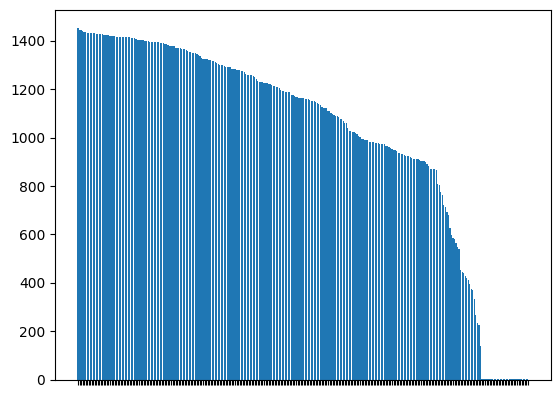

In [19]:
# here we plot the sizes in decreasing order

import matplotlib.pyplot as plt

sizeCheck = {k: v for k, v in sorted(sizeCheck.items(), key=lambda item: item[1], reverse=True)}

plt.bar(sizeCheck.keys(), sizeCheck.values())
plt.xticks(labels=["" for i in range(0, len(sizeCheck.keys()))], ticks=[i for i in range(0, len(sizeCheck.keys()))])

plt.show();

In [20]:
# select the countries_codes with at most 1000 features

selected_countries = [country for country in sizeCheck if sizeCheck[country] >= 900]

print('Number Selected Countries: ', len(selected_countries))


# find the intersection of features selected countries
selected_feats = set(countries_dict[selected_countries[0]].columns)


for country in selected_countries:
    selected_feats = selected_feats.intersection(set(countries_dict[country].columns))


print('Number of features: ', len(selected_feats))
print('Selected Features: ', selected_feats)

Number Selected Countries:  229
Number of features:  197
Selected Features:  {'NV.IND.TOTL.ZS', 'TM.VAL.MRCH.AL.ZS', 'NV.AGR.TOTL.ZS', 'TM.VAL.MRCH.R6.ZS', 'SP.POP.0004.MA.5Y', 'NV.IND.TOTL.CD', 'SP.POP.1564.TO.ZS', 'SP.POP.6064.FE.5Y', 'SP.POP.5054.FE.5Y', 'TX.VAL.MRCH.HI.ZS', 'SP.DYN.LE00.MA.IN', 'TM.VAL.MRCH.R1.ZS', 'EG.ELC.ACCS.ZS', 'NY.GDP.MKTP.CD', 'TM.VAL.MRCH.R5.ZS', 'AG.LND.ARBL.HA.PC', 'SP.POP.1519.FE.5Y', 'AG.LND.EL5M.ZS', 'NY.GDP.PCAP.KD.ZG', 'EN.ATM.CO2E.PC', 'NY.GNP.MKTP.KD', 'EN.ATM.CO2E.LF.KT', 'NY.ADJ.DCO2.GN.ZS', 'EG.FEC.RNEW.ZS', 'AG.PRD.FOOD.XD', 'AG.LND.EL5M.RU.ZS', 'TX.VAL.MRCH.R6.ZS', 'SP.DYN.AMRT.MA', 'TX.VAL.MRCH.AL.ZS', 'SE.SEC.ENRL.GC.FE.ZS', 'SP.POP.1519.MA.5Y', 'TX.VAL.MRCH.WL.CD', 'SE.SEC.ENRL', 'AG.LND.AGRI.ZS', 'SP.POP.GROW', 'AG.LND.EL5M.UR.ZS', 'IT.NET.BBND', 'NY.GDP.MINR.RT.ZS', 'SP.POP.2529.FE.5Y', 'SP.POP.0014.MA.IN', 'SP.POP.5559.MA.5Y', 'ER.PTD.TOTL.ZS', 'AG.LND.TOTL.RU.K2', 'TX.VAL.MRCH.R2.ZS', 'IT.NET.BBND.P2', 'SP.POP.1564.MA.ZS', 'EN.POP.EL5M.

In [21]:
analysis_dataframe = pd.DataFrame()


for country in tqdm(selected_countries, desc='Processing countries'):
    feats_subset = countries_dict[country][list(selected_feats)]


    analysis_dataframe = pd.concat([analysis_dataframe, feats_subset], axis=0)

print(analysis_dataframe)



Processing countries: 100%|██████████| 229/229 [00:02<00:00, 83.99it/s] 

      NV.IND.TOTL.ZS  TM.VAL.MRCH.AL.ZS  NV.AGR.TOTL.ZS  TM.VAL.MRCH.R6.ZS  \
1960             NaN           0.193317       40.851554           5.081469   
1961             NaN           0.827482       35.376344           5.441324   
1962             NaN           0.990396       37.892604           5.582233   
1963             NaN           1.263042       35.909091           5.381658   
1964             NaN           2.233980       35.355987           7.142857   
...              ...                ...             ...                ...   
2018       22.249243           3.119667        1.511697           1.561213   
2019       22.194625           2.990241        1.477974           1.581943   
2020       22.224336           2.155829        1.514839           1.417684   
2021       22.571281                NaN        1.486999                NaN   
2022       23.086111                NaN        1.572767                NaN   

      SP.POP.0004.MA.5Y  NV.IND.TOTL.CD  SP.POP.1564.TO.ZS  SP.

In [22]:
# select only the columns that have at least 90% of non-null values
subset_90perc = analysis_dataframe.dropna(thresh=0.9*len(analysis_dataframe), axis=1)

gdp_cols = [col for col in subset_90perc.columns if 'GDP' in col]

print('GDP Columns: ', gdp_cols)

GDP Columns:  []


In [23]:
# import seaborn as sns
import matplotlib.pyplot as plt
# Load the data
with open('clean_data/countries_dict2.pkl', 'rb') as f:
    countries_dict2 = pickle.load(f)

# select only the subset of data containing at least 100% of the data
interesting_ita_subset = countries_dict2['ITA'].dropna(thresh=1*len(countries_dict2['ITA']), axis=1)

# Select the gdp variable "NY.GDP.MKTP.CD": "GDP (current US$)", and add a new column called target being the gdp of the next year
interesting_ita_subset['target'] = interesting_ita_subset['NY.GDP.MKTP.CD'].shift(-1)

print(interesting_ita_subset)
# Drop the last row
last_row = interesting_ita_subset.tail(1)
interesting_ita_subset = interesting_ita_subset.drop(interesting_ita_subset.tail(1).index)

corr_matrix = interesting_ita_subset.corr(method='pearson')


# plt.figure(figsize=(10, 8))
# heatmap = sns.heatmap(corr_matrix, annot=False)
# plt.title('Heatmap of the Dataset')
# plt.show()


      SP.RUR.TOTL.ZG  SP.POP.65UP.MA.ZS  SP.POP.DPND  SP.POP.DPND.OL  \
1960        0.775953           8.380861    52.722952       14.526702   
1961       -0.557139           8.450388    52.927334       14.767429   
1962       -0.574190           8.514063    52.742126       14.952589   
1963       -0.534554           8.549372    52.502241       15.074072   
1964       -0.455075           8.616684    52.563762       15.258112   
...              ...                ...          ...             ...   
2018       -1.179670          20.307281    56.294408       35.575857   
2019       -2.166198          20.623315    56.547934       36.104456   
2020       -1.527891          20.942262    56.813740       36.650620   
2021       -1.581309          21.249813    57.065307       37.193657   
2022       -1.417780          21.625848    57.440220       37.870008   

      SP.POP.TOTL.MA.IN  SP.POP.GROW  SP.URB.GROW  EN.URB.MCTY.TL.ZS  \
1960         24345052.0     1.993928     2.836401          15.8

08/07/2024 05:58:18PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:18PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


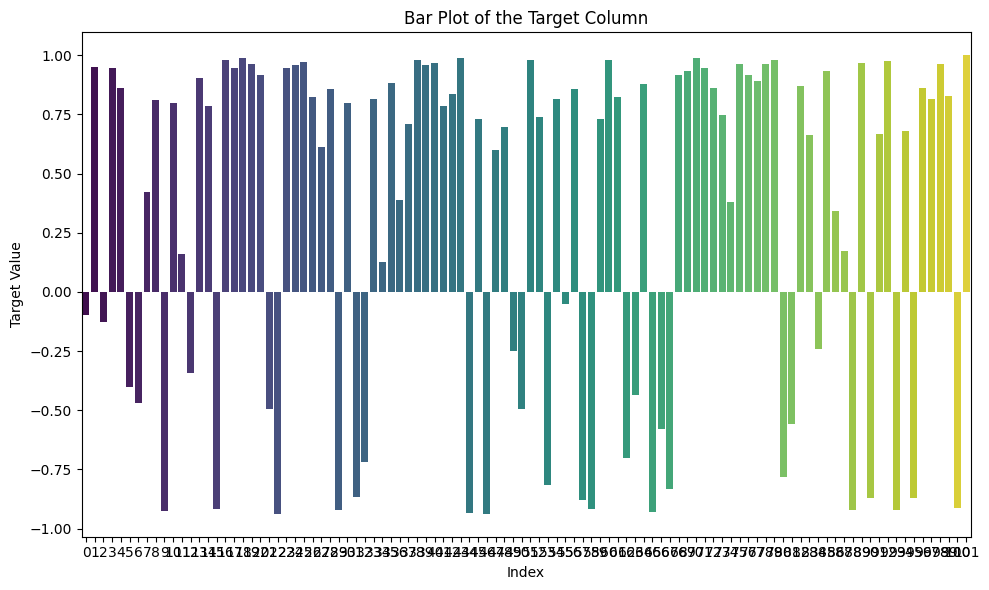

In [24]:
import seaborn as sns

# Extract data for the 'Target' column
target_data = corr_matrix['target']

# Plot the 'Target' column as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=[str(elem) for elem in range(len(target_data.values))], y=target_data.values, palette='viridis')
plt.title('Bar Plot of the Target Column')
plt.xlabel('Index')
plt.ylabel('Target Value')
plt.tight_layout()
plt.show()

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


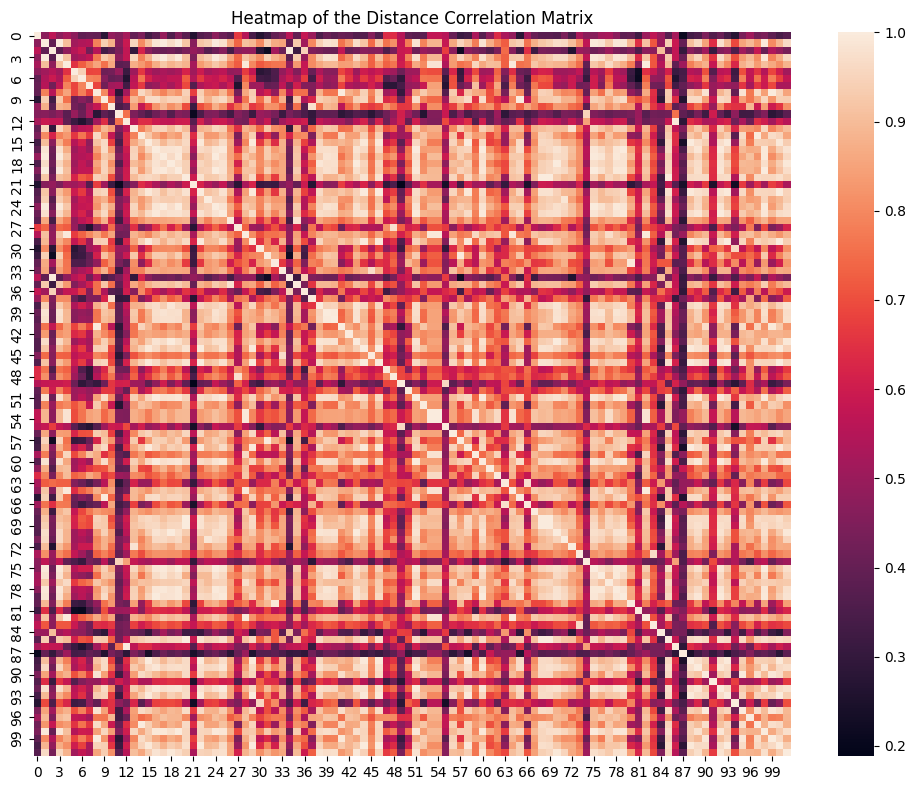

In [25]:
empty_matrix = np.zeros((len(interesting_ita_subset.columns), len(interesting_ita_subset.columns)))
# set on the main diagonal all ones
np.fill_diagonal(empty_matrix, 1)

print(empty_matrix)

# Help me create the distance correlation matrix without repeating the same calculations
for i, column1 in enumerate(interesting_ita_subset.columns):
    column1_distance_vec = np.zeros((len(interesting_ita_subset), 1))
    for j, column2 in enumerate(interesting_ita_subset.columns[i+1:], start=i+1):
        distance_corr = dcor.distance_correlation(interesting_ita_subset[column1], interesting_ita_subset[column2].values)
        empty_matrix[i, j] = distance_corr
        empty_matrix[j, i] = distance_corr

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(empty_matrix, annot=False)
plt.title('Heatmap of the Distance Correlation Matrix')
plt.tight_layout()
plt.show()


    

08/07/2024 05:58:20PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:20PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


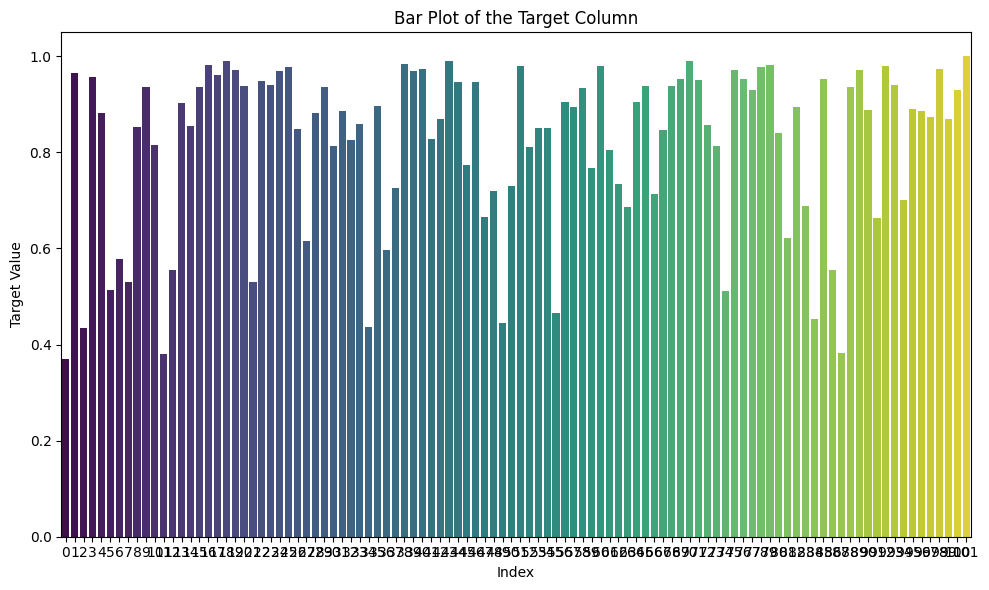

In [26]:
# Extract data for the 'Target' column
target_data = empty_matrix[:, -1]

# Plot the 'Target' column as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=[str(elem) for elem in range(len(target_data))], y=target_data, palette='viridis')
plt.title('Bar Plot of the Target Column')
plt.xlabel('Index')
plt.ylabel('Target Value')
plt.tight_layout()
plt.show()

In [27]:
# create a subset of interesting_ita_subset with only the columns that have a correlation with the target greater than 0.8
columnsToKeep = target_data > 0.8

highCorr_ita_subset = interesting_ita_subset[interesting_ita_subset.columns[columnsToKeep]]

print(len(highCorr_ita_subset.columns))

72


08/07/2024 05:58:21PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:21PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


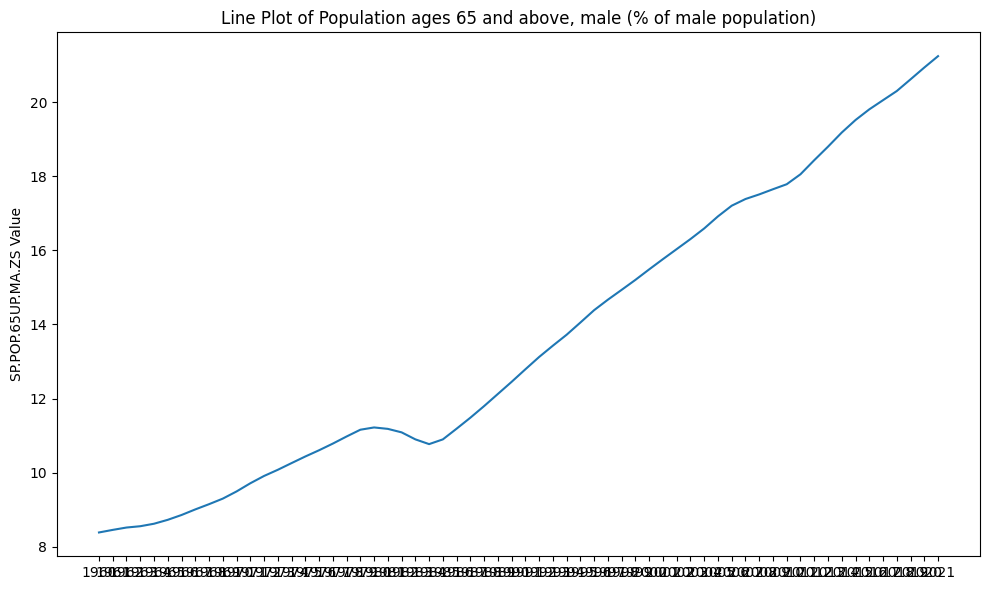

08/07/2024 05:58:21PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:21PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


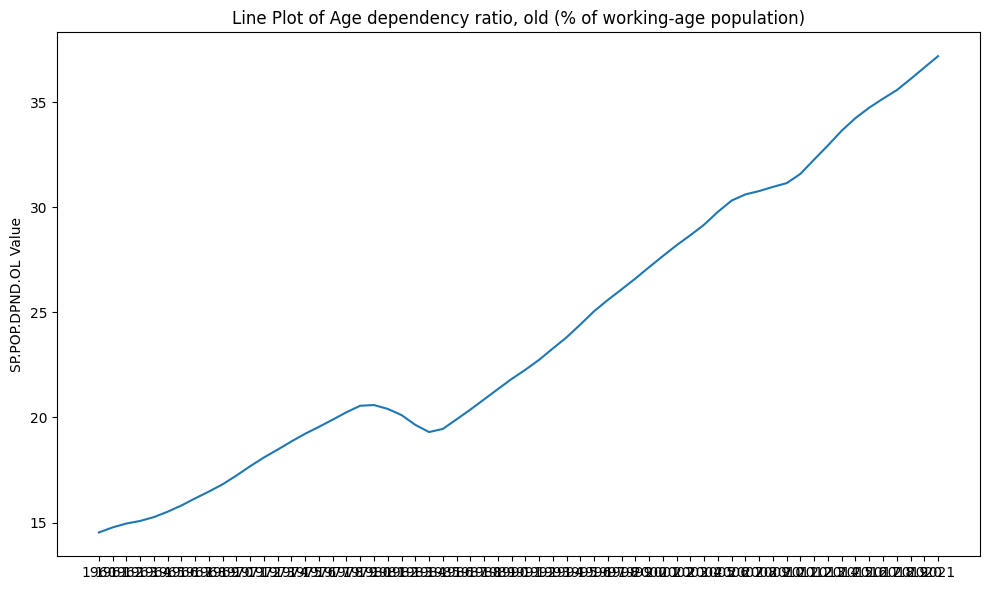

08/07/2024 05:58:22PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:22PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


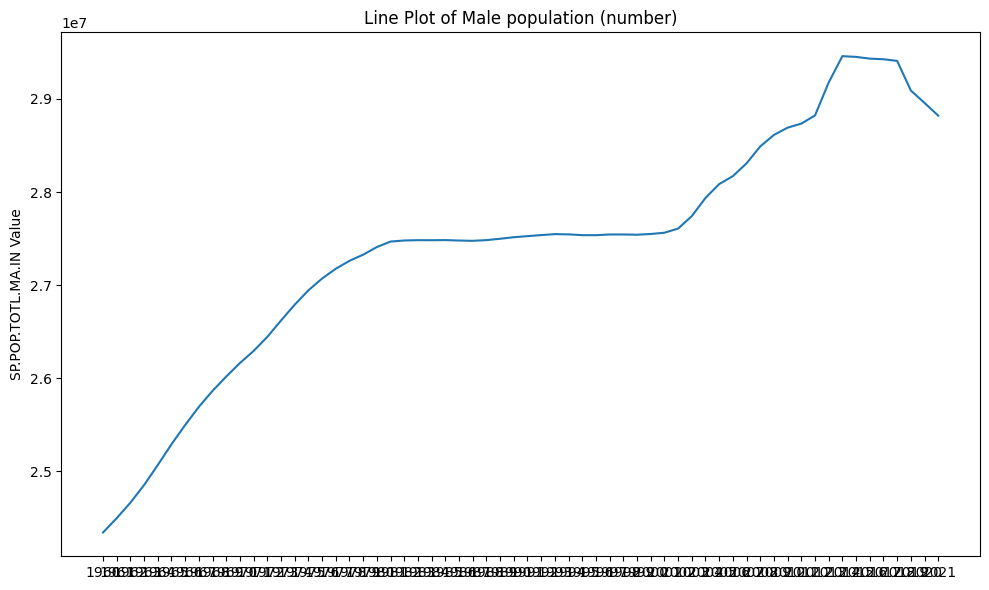

08/07/2024 05:58:22PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:22PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


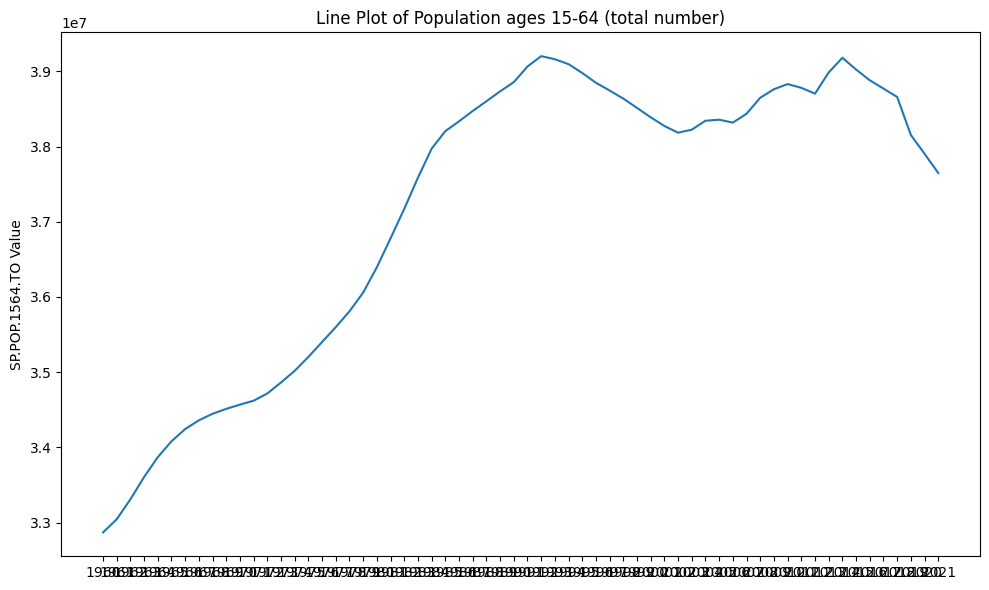

08/07/2024 05:58:22PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:22PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


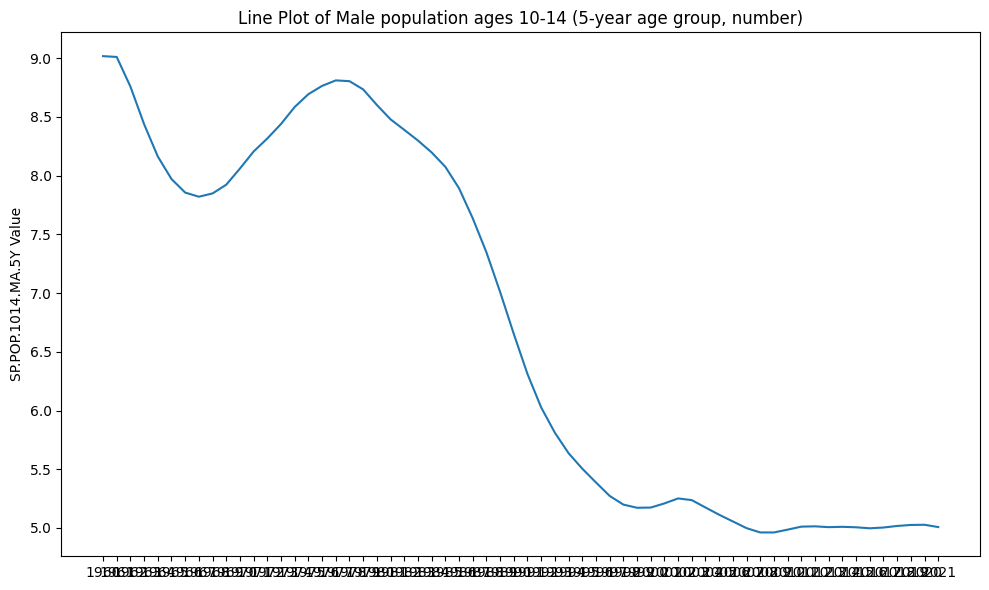

08/07/2024 05:58:22PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:22PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


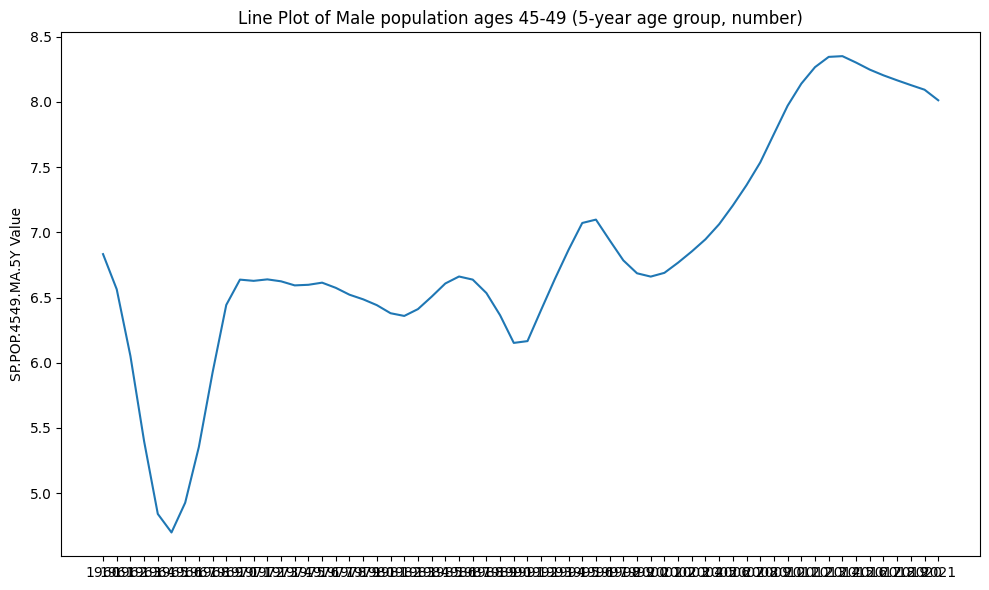

08/07/2024 05:58:23PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:23PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


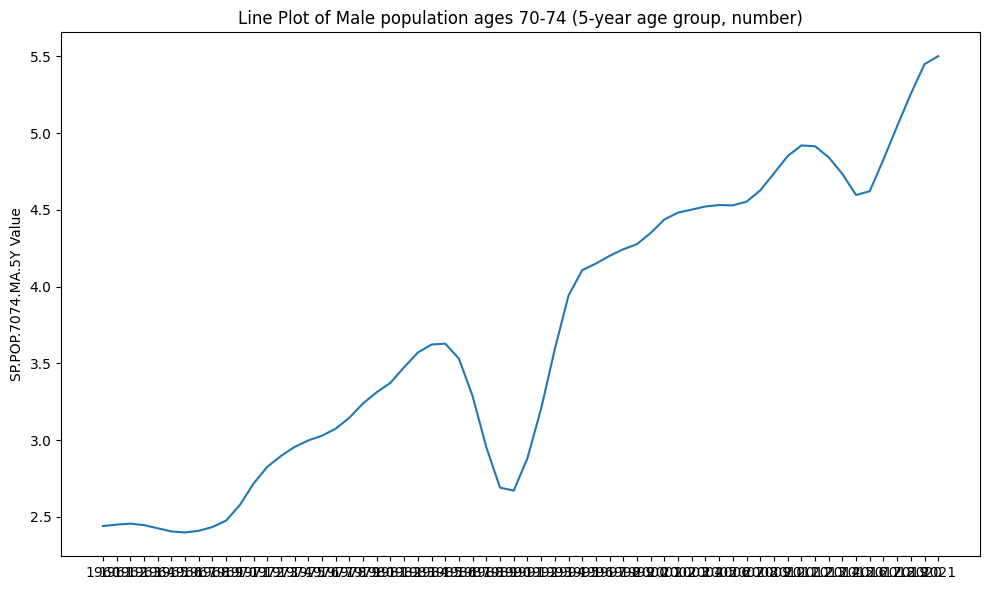

08/07/2024 05:58:23PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:23PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


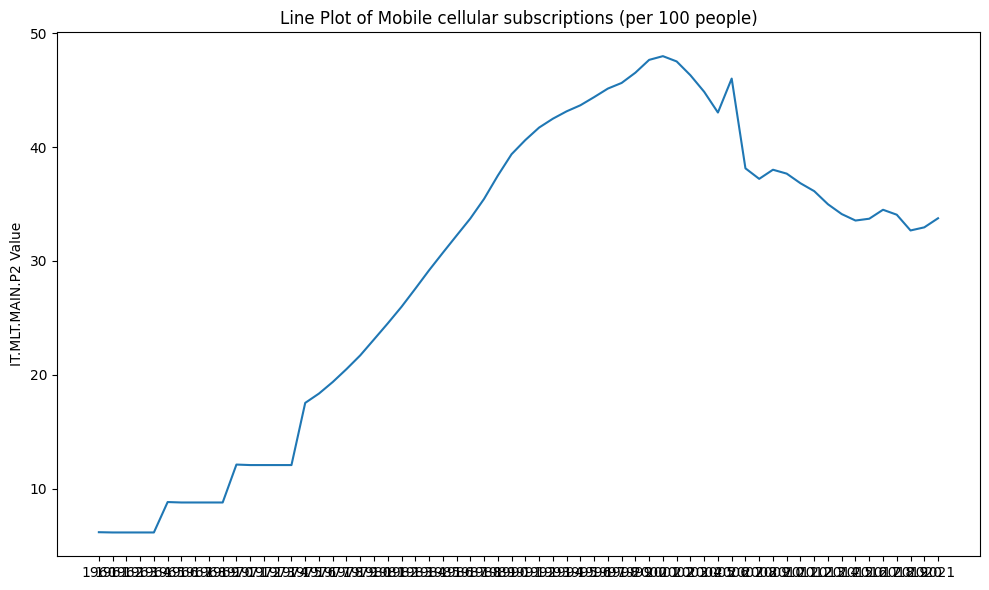

08/07/2024 05:58:23PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:23PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


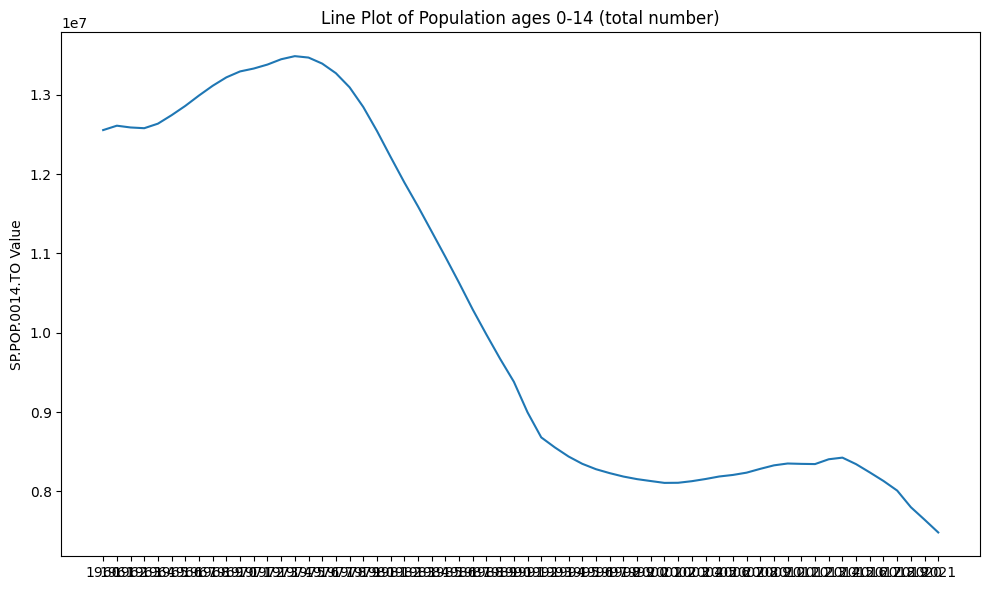

08/07/2024 05:58:23PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:23PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


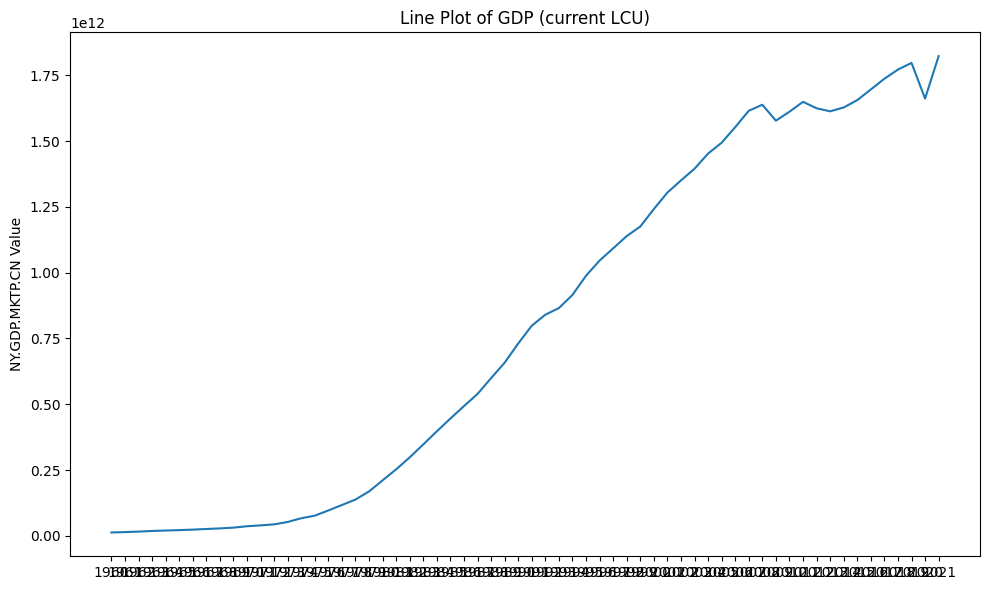

08/07/2024 05:58:24PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:24PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


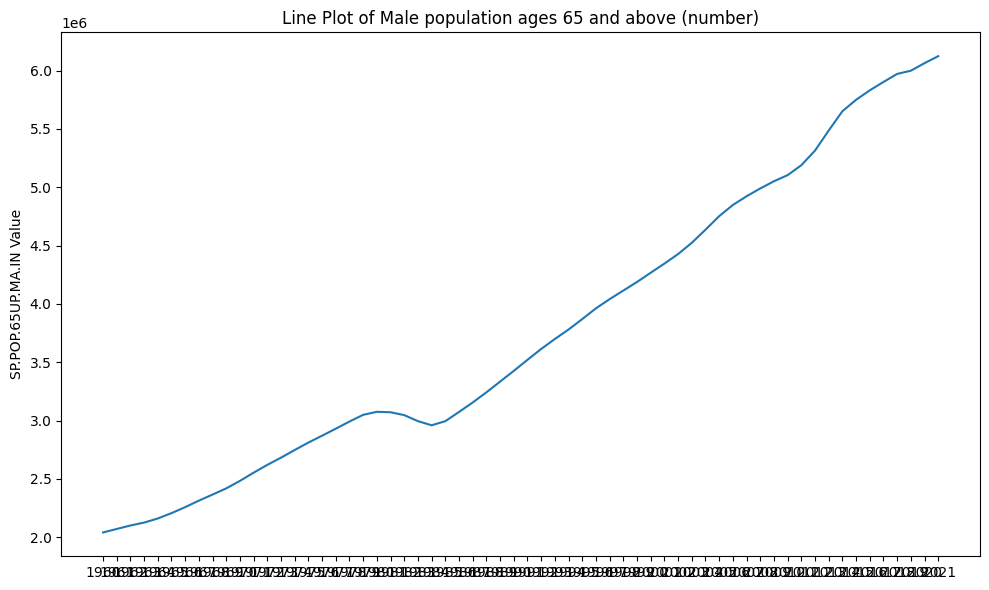

08/07/2024 05:58:24PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:24PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


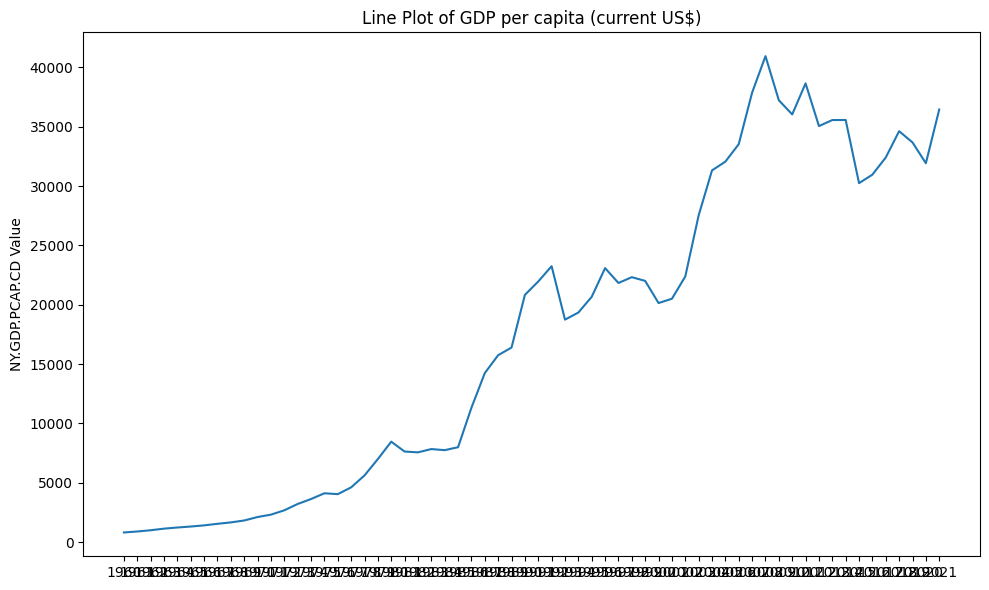

08/07/2024 05:58:24PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:24PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


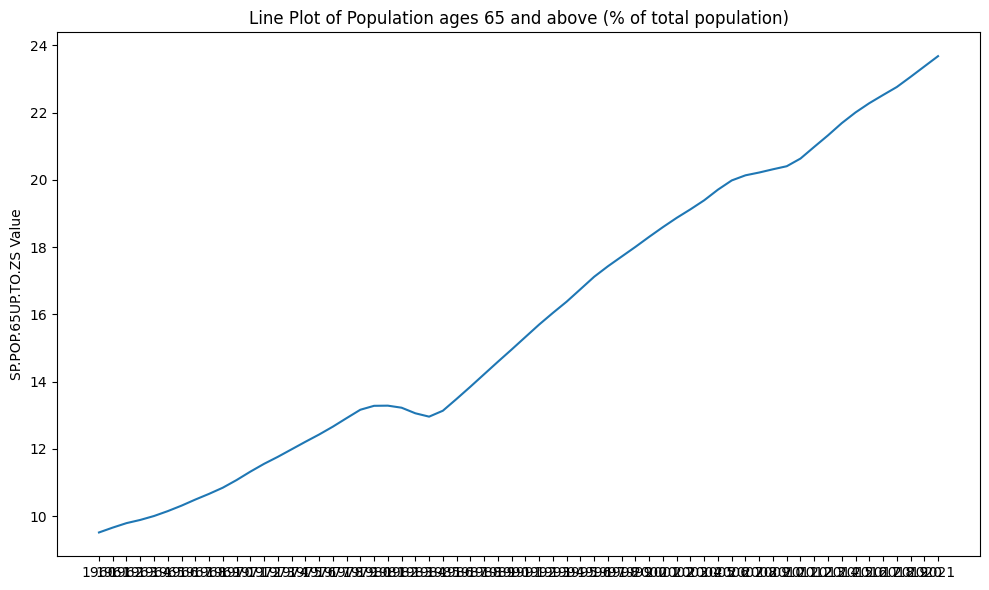

08/07/2024 05:58:25PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:25PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


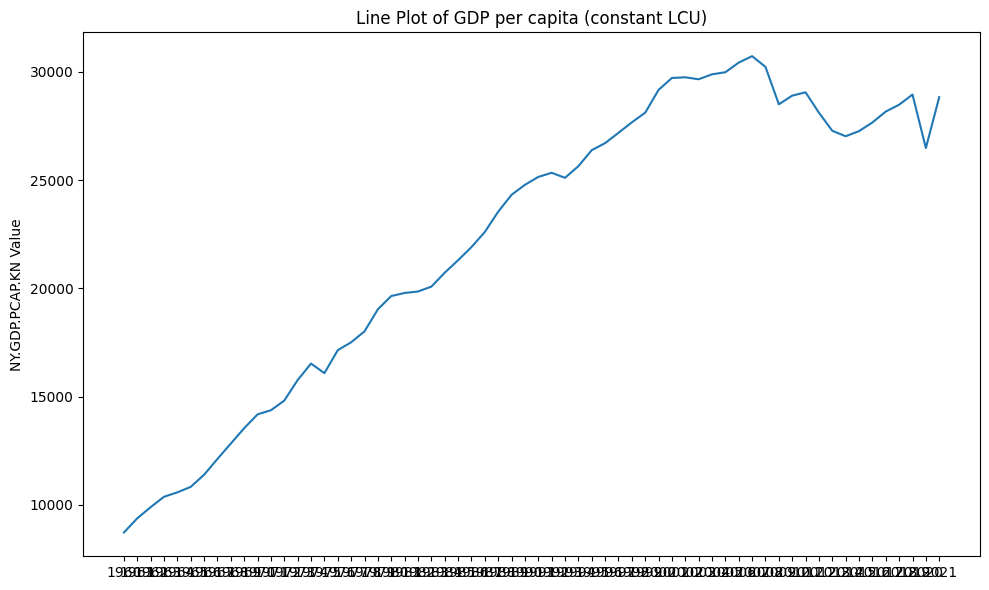

08/07/2024 05:58:26PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:26PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


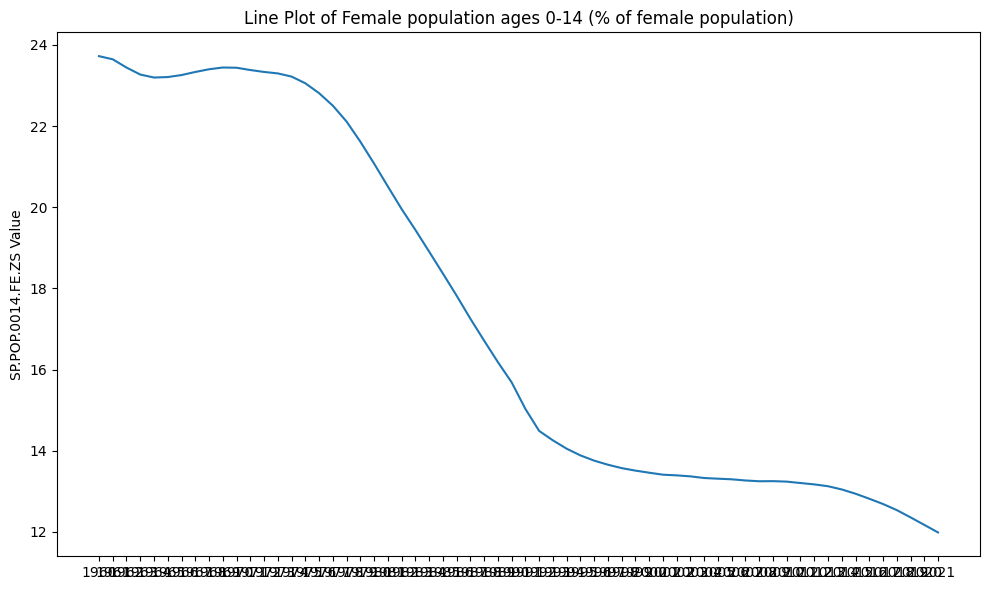

08/07/2024 05:58:26PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:26PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


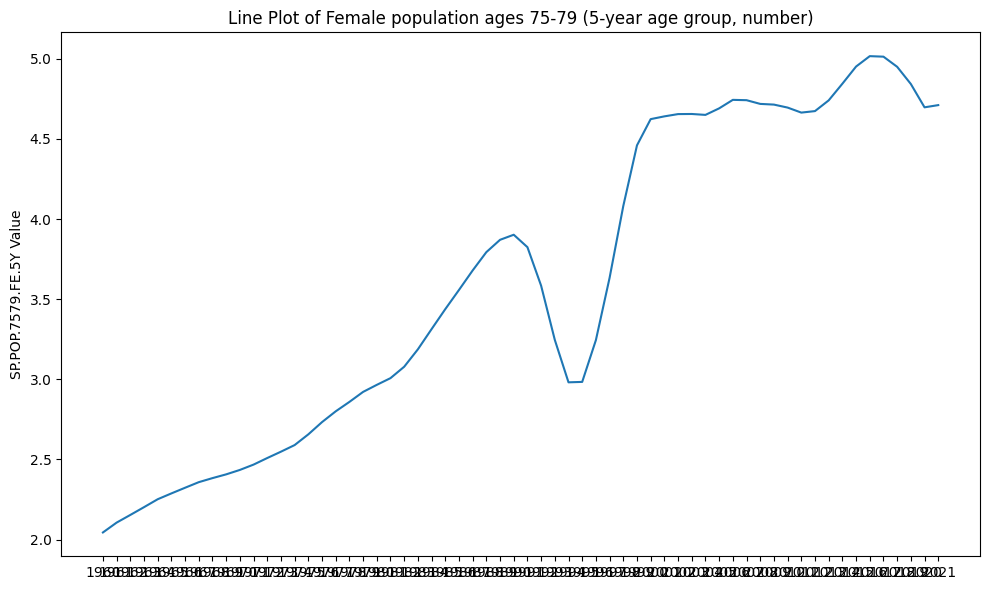

08/07/2024 05:58:26PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:26PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


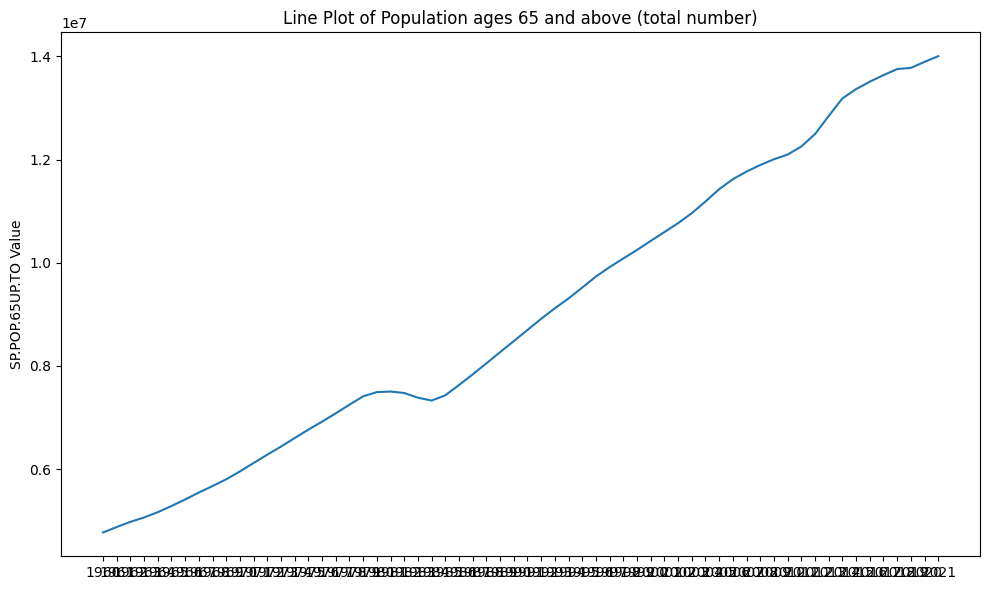

08/07/2024 05:58:26PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:26PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


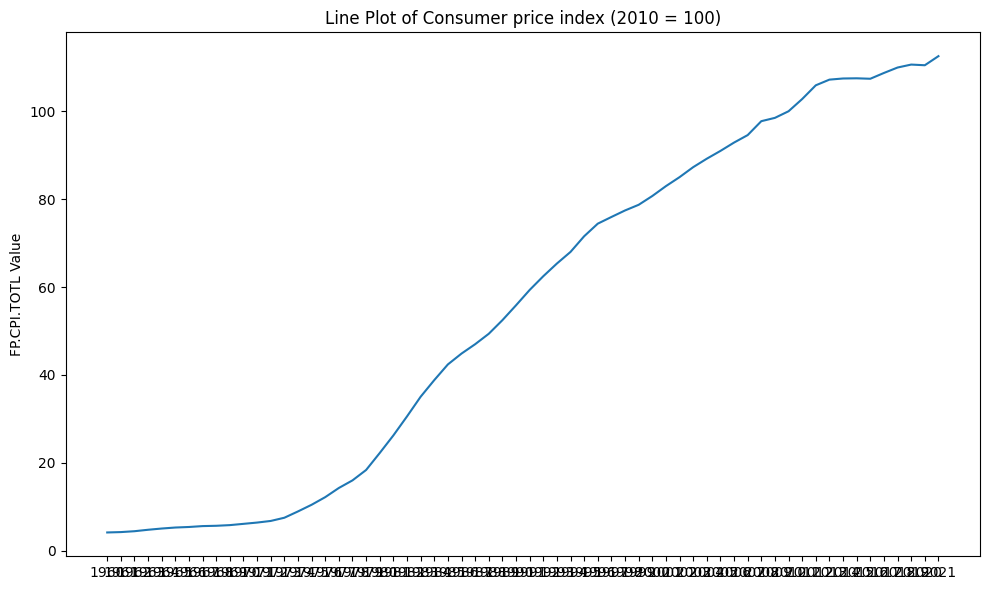

08/07/2024 05:58:27PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:27PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


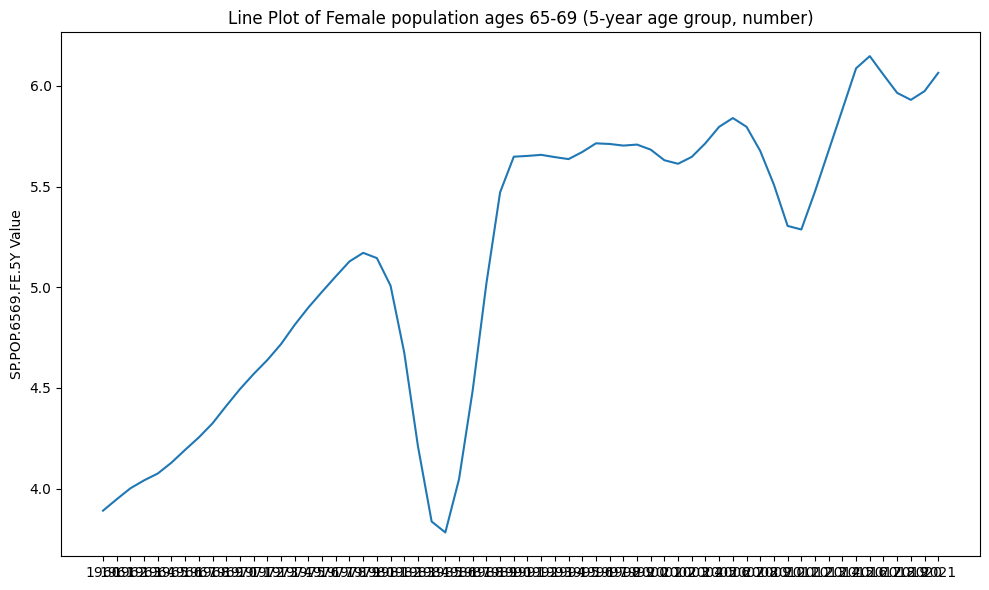

08/07/2024 05:58:27PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:27PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


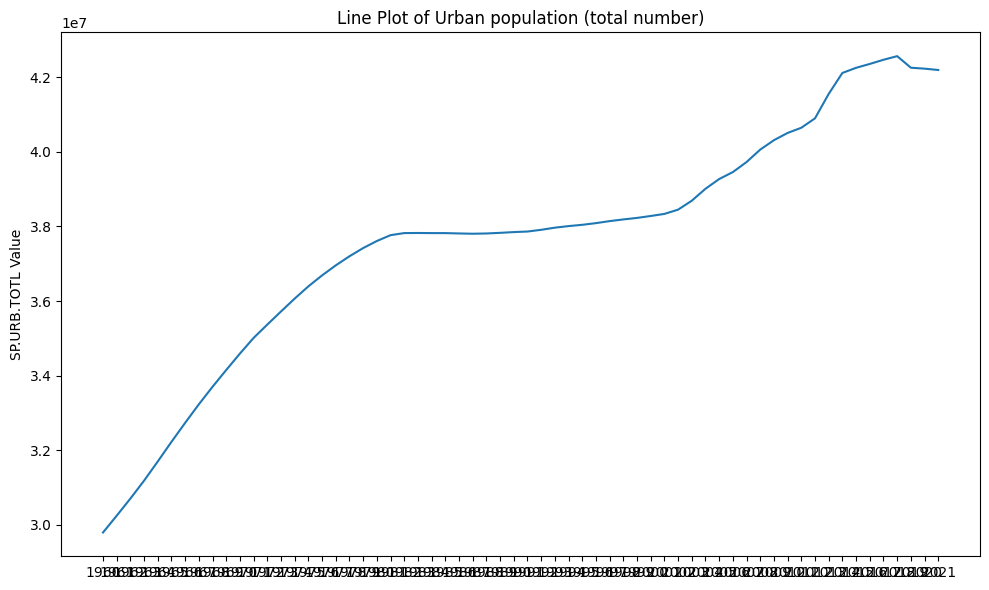

08/07/2024 05:58:27PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:27PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


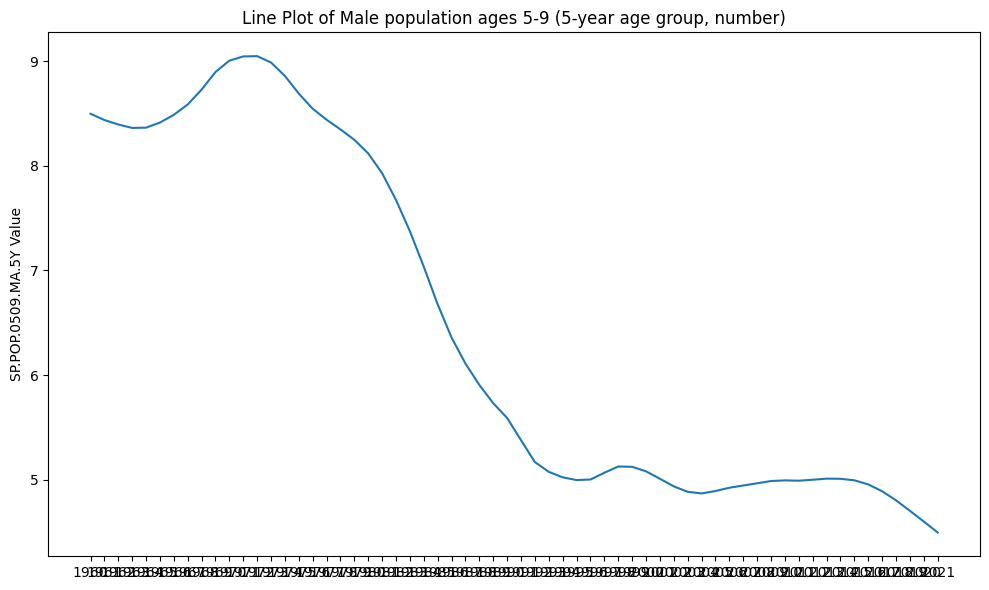

08/07/2024 05:58:27PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:27PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


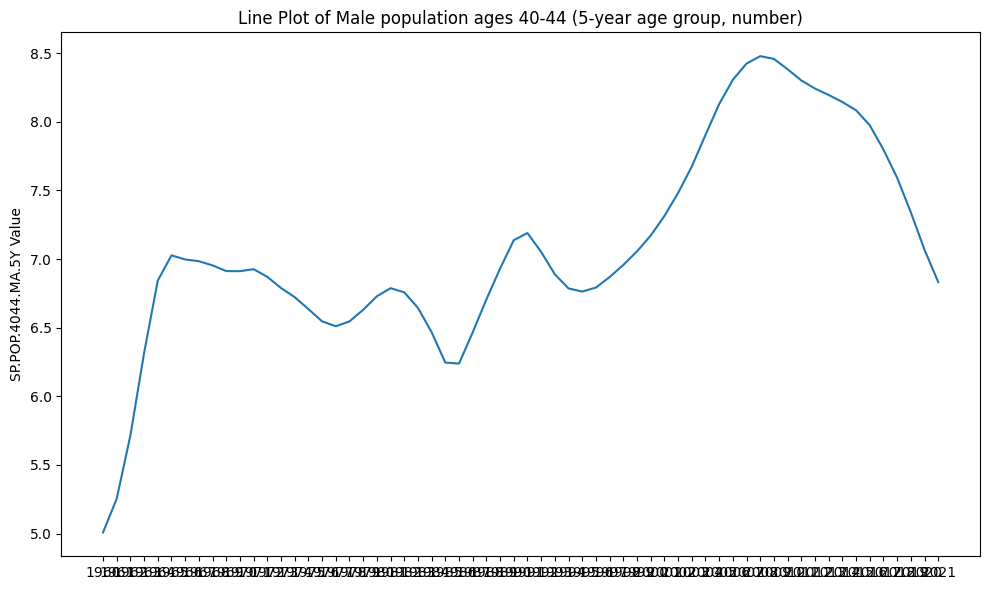

08/07/2024 05:58:28PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:28PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


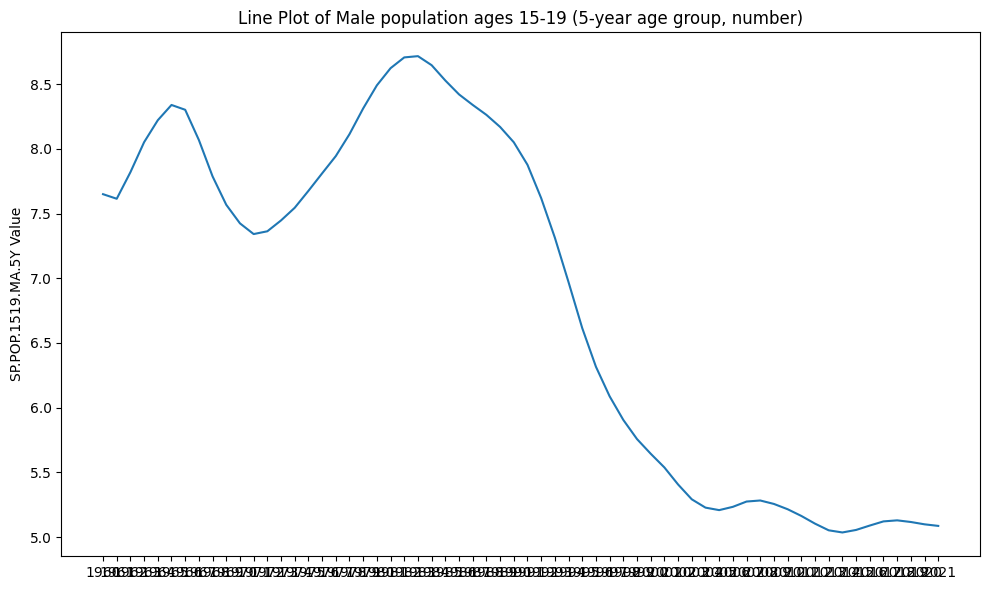

08/07/2024 05:58:28PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:28PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


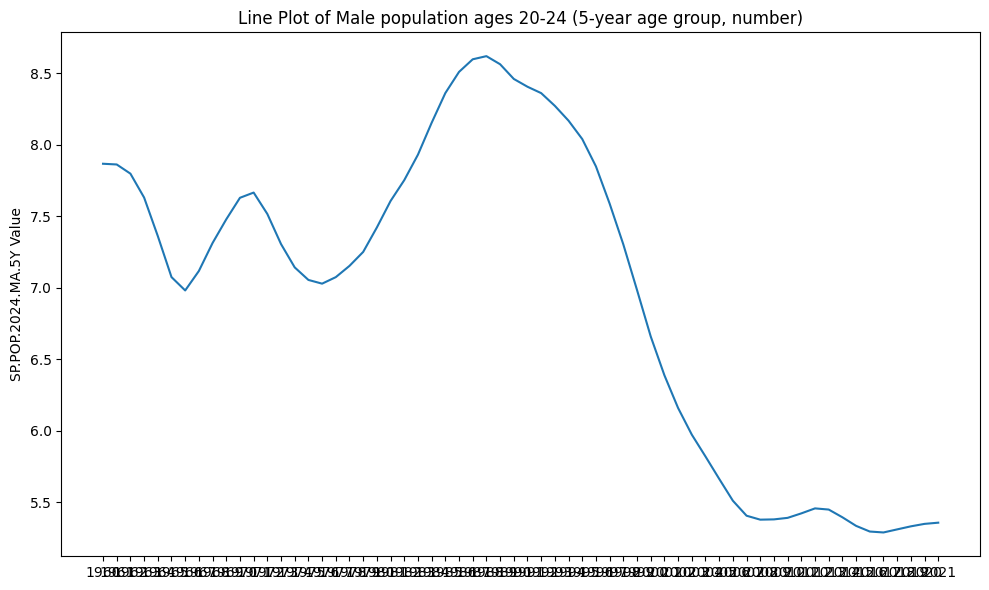

08/07/2024 05:58:28PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:28PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


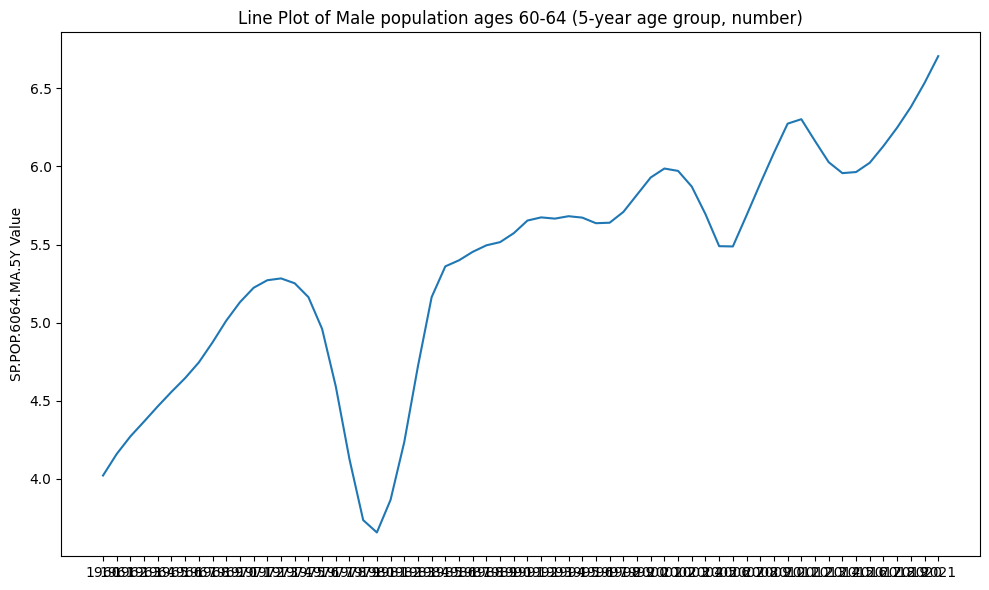

08/07/2024 05:58:28PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:28PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


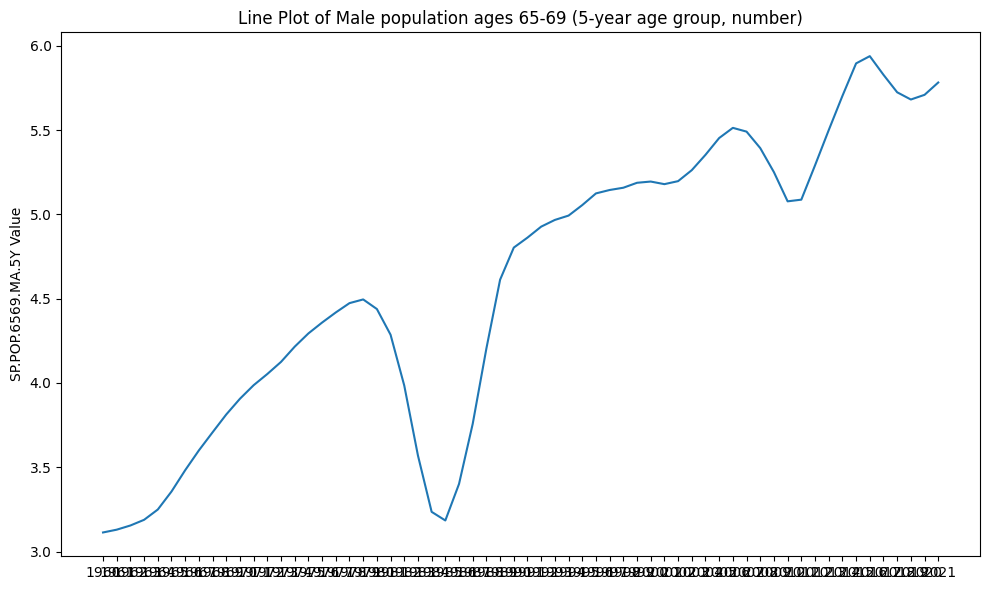

08/07/2024 05:58:29PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:29PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


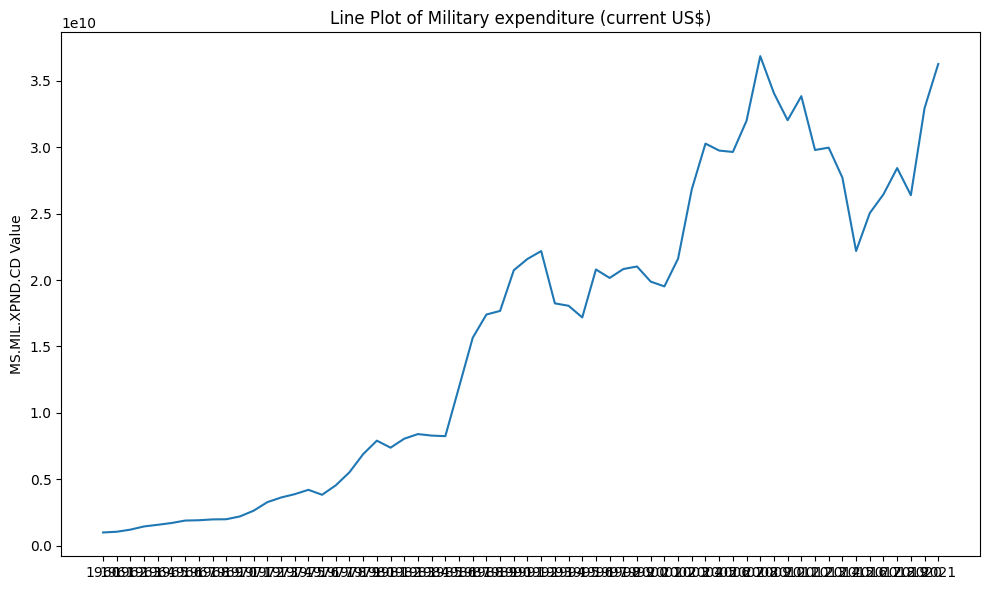

08/07/2024 05:58:29PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:29PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


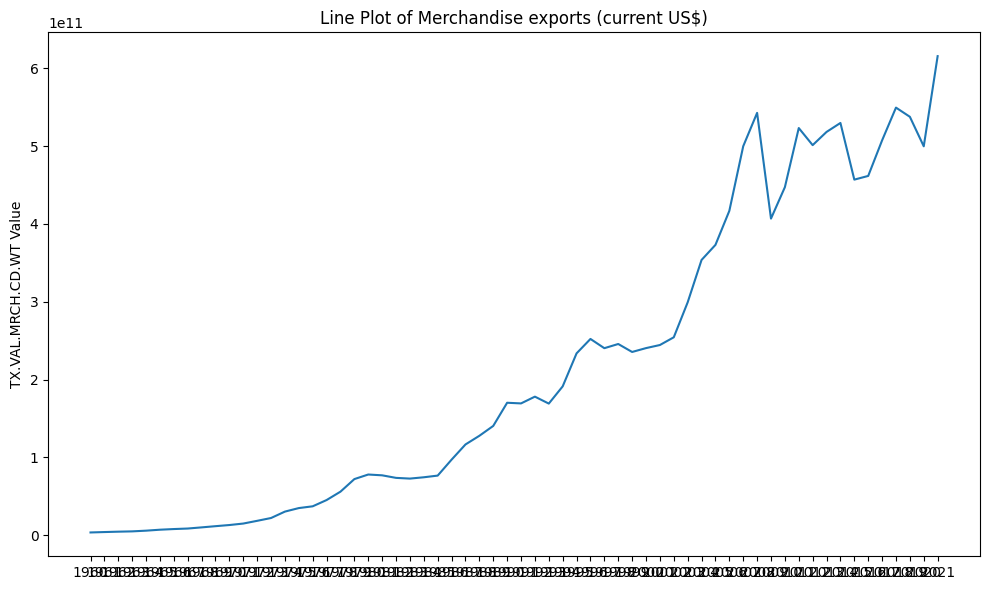

08/07/2024 05:58:29PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:29PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


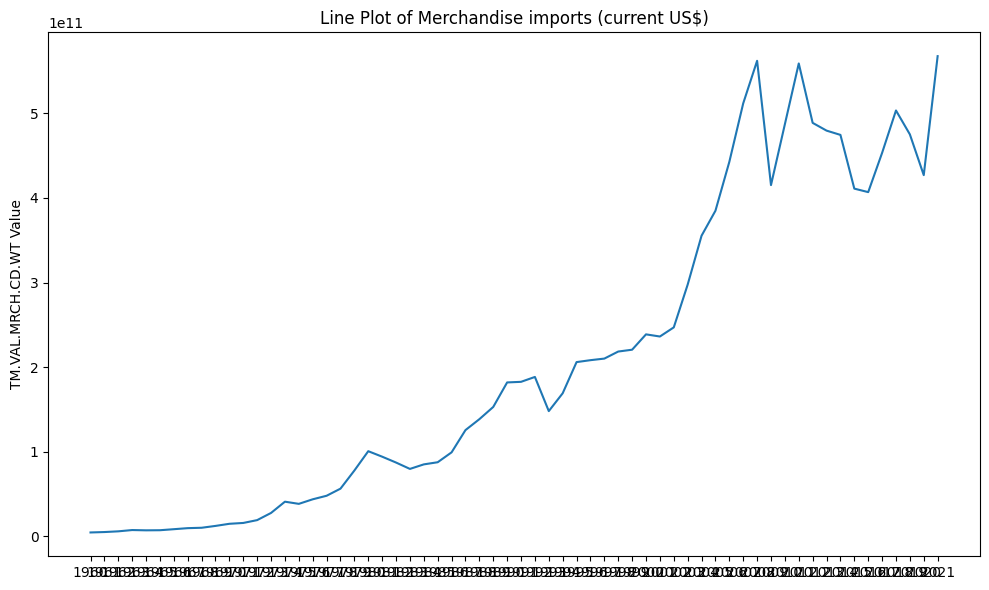

08/07/2024 05:58:30PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:30PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


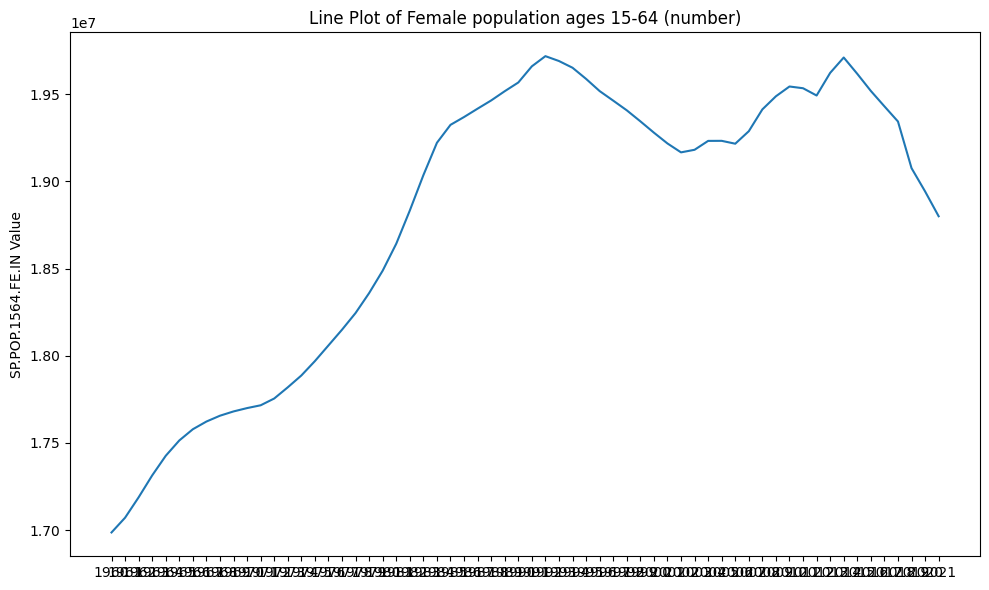

08/07/2024 05:58:30PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:30PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


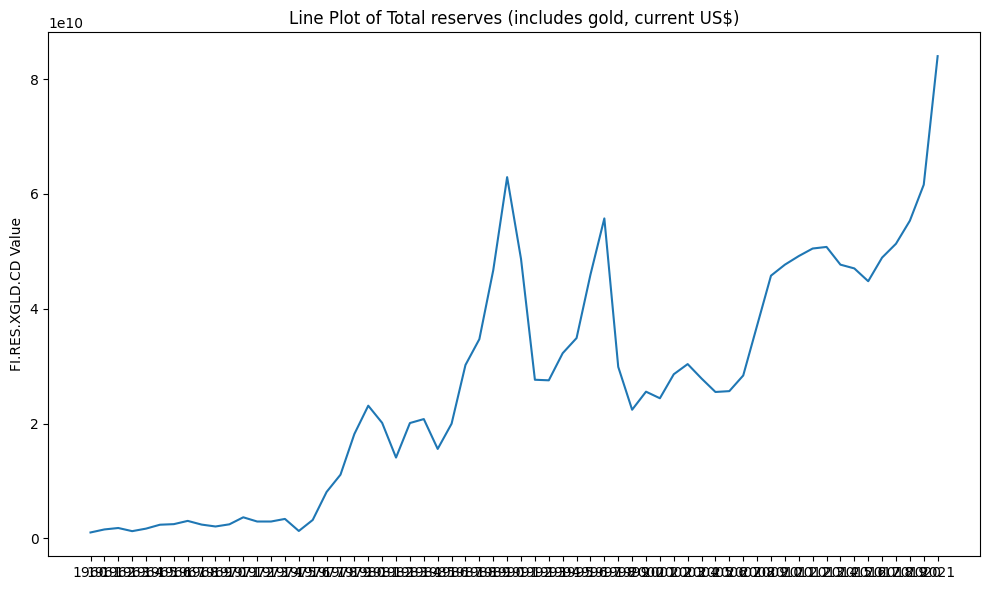

08/07/2024 05:58:30PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:30PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


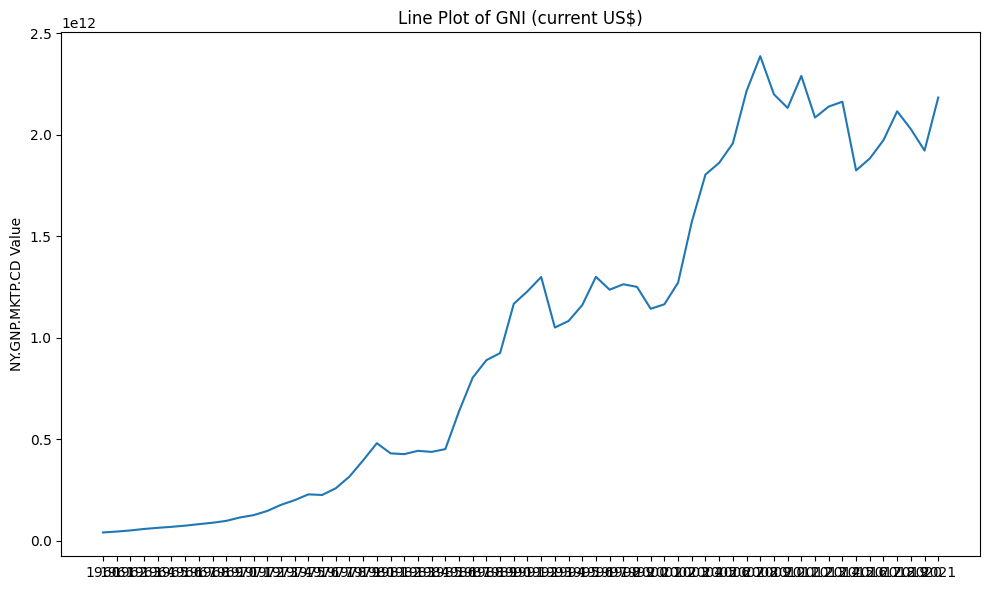

08/07/2024 05:58:30PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:30PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


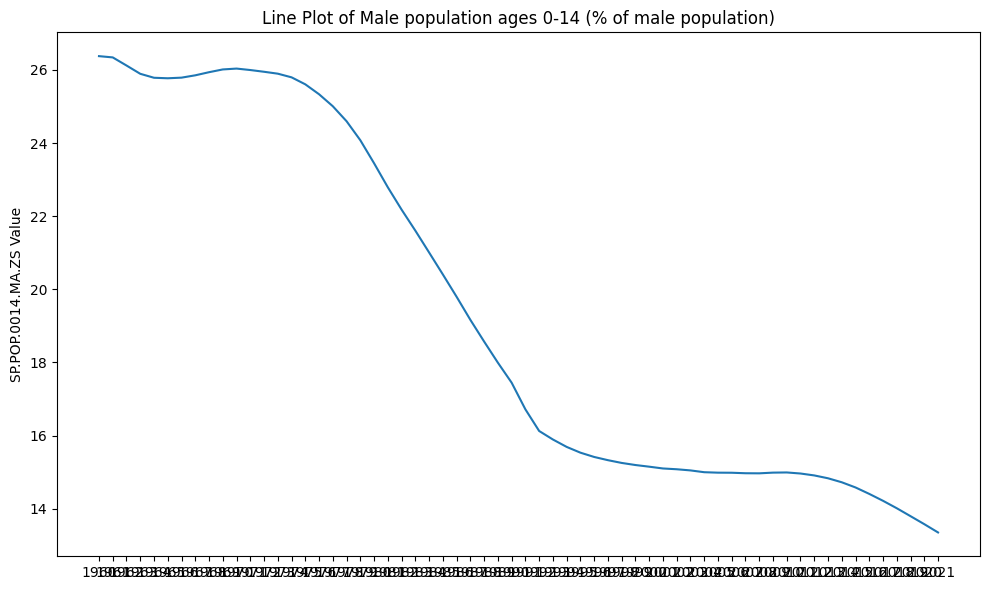

08/07/2024 05:58:31PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:31PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


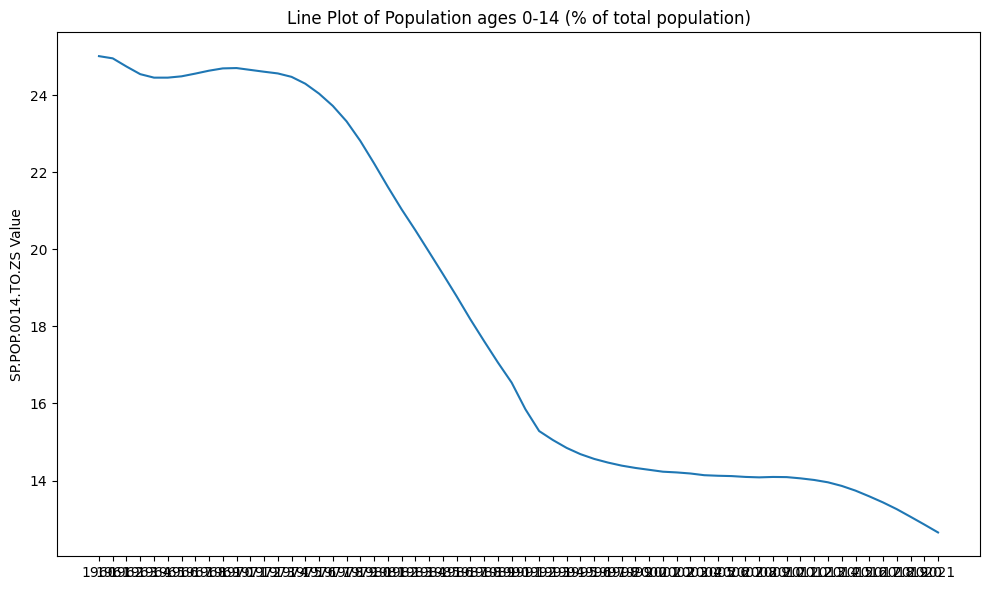

08/07/2024 05:58:31PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:31PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


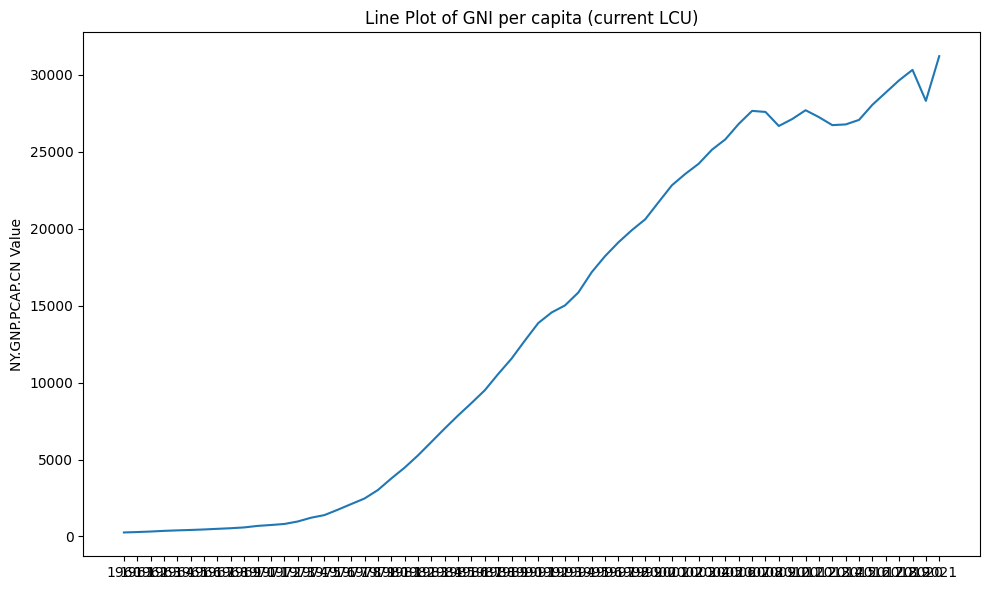

08/07/2024 05:58:31PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:31PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


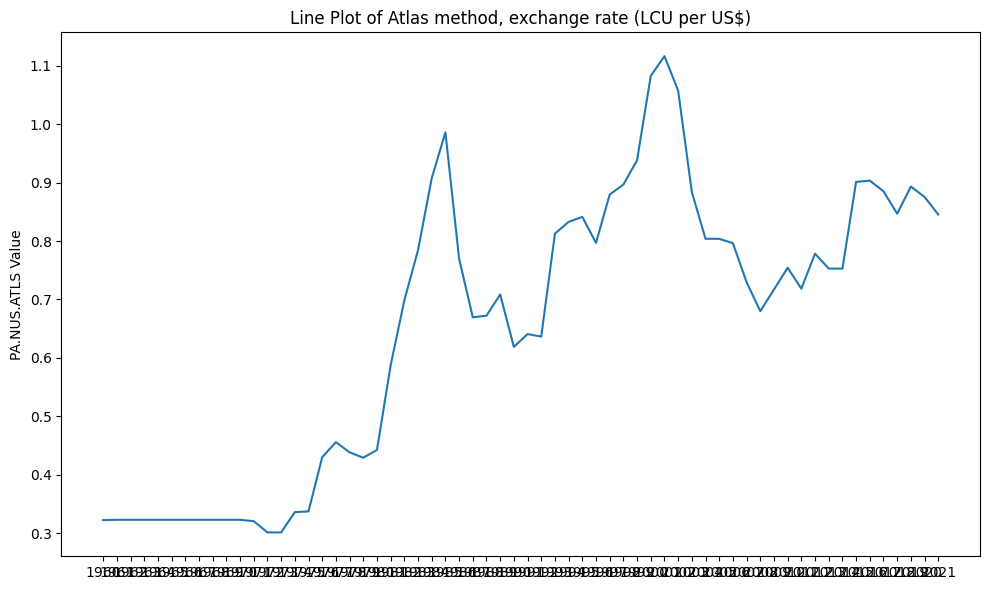

08/07/2024 05:58:31PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:31PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


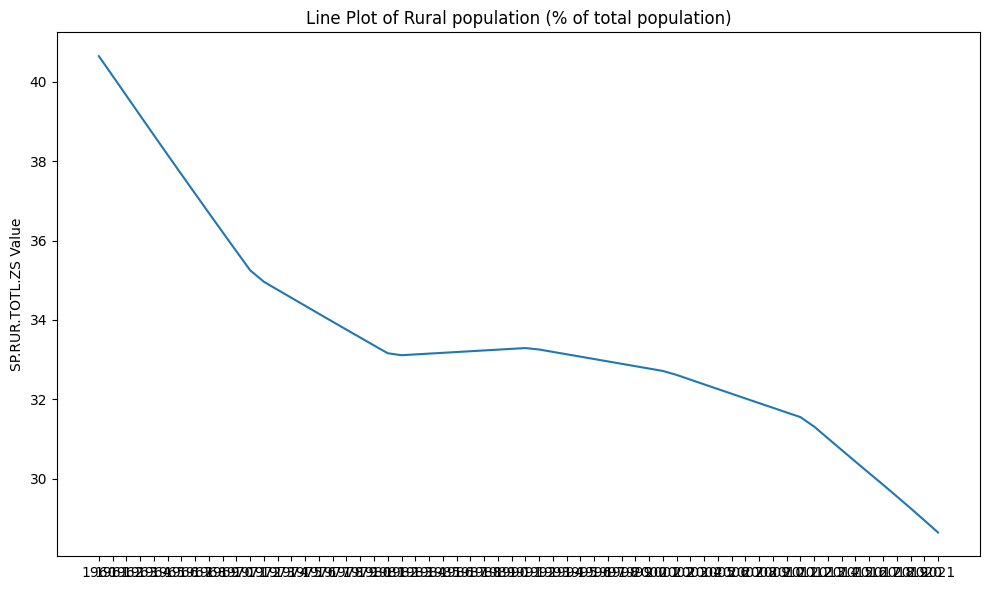

08/07/2024 05:58:32PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:32PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


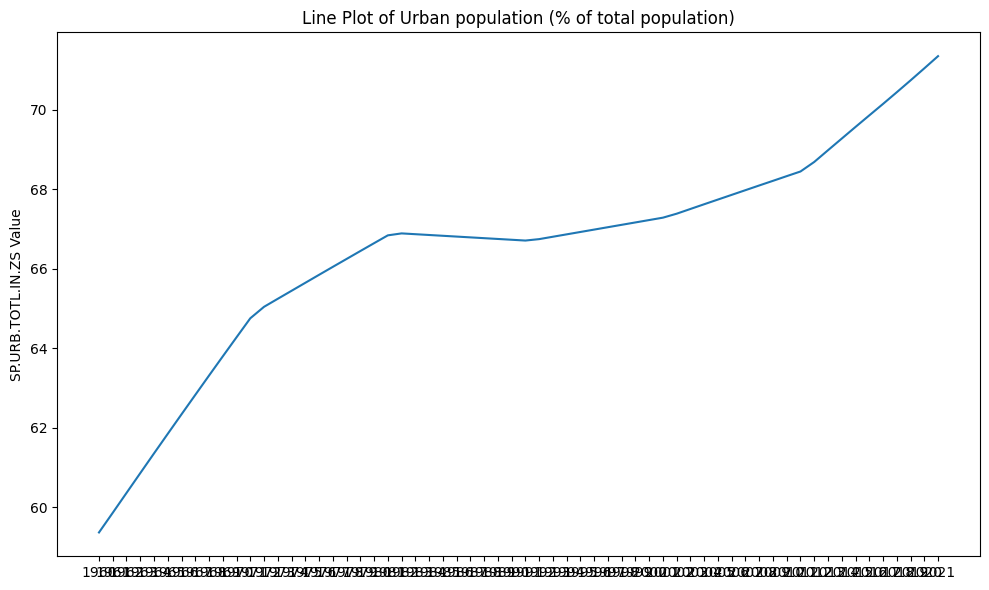

08/07/2024 05:58:32PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:32PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


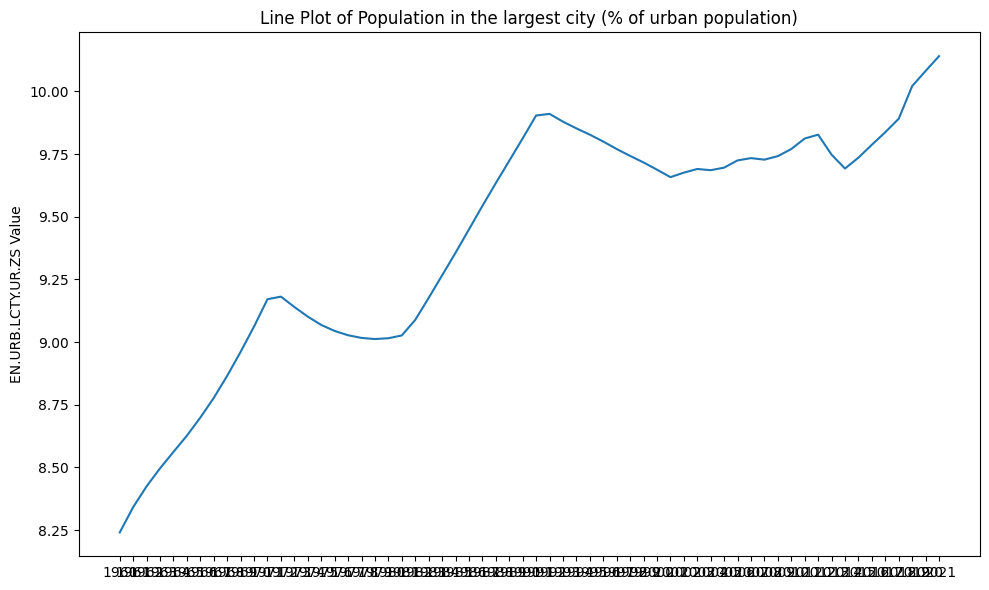

08/07/2024 05:58:32PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:32PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


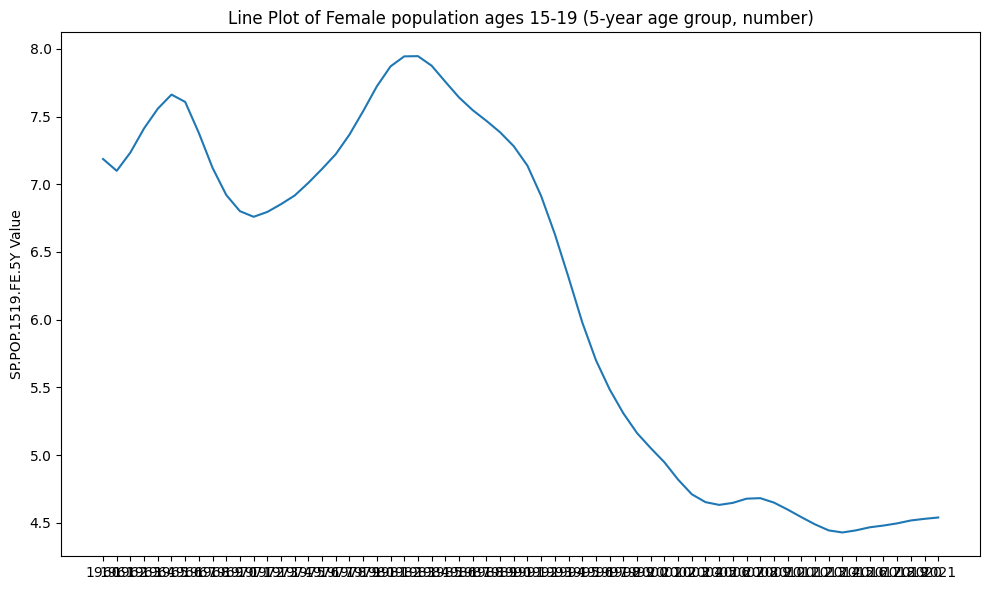

08/07/2024 05:58:32PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:32PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


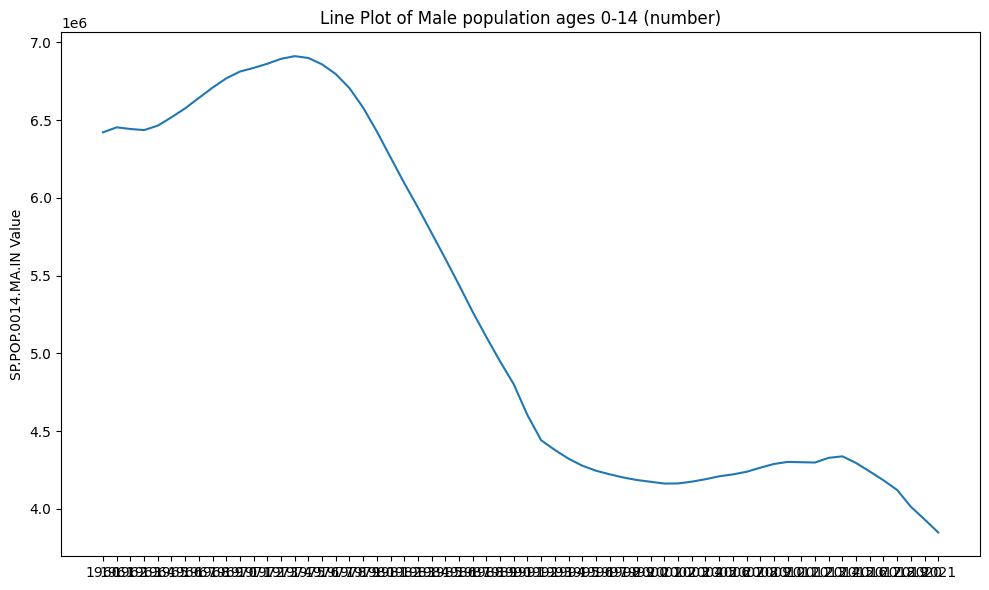

08/07/2024 05:58:33PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:33PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


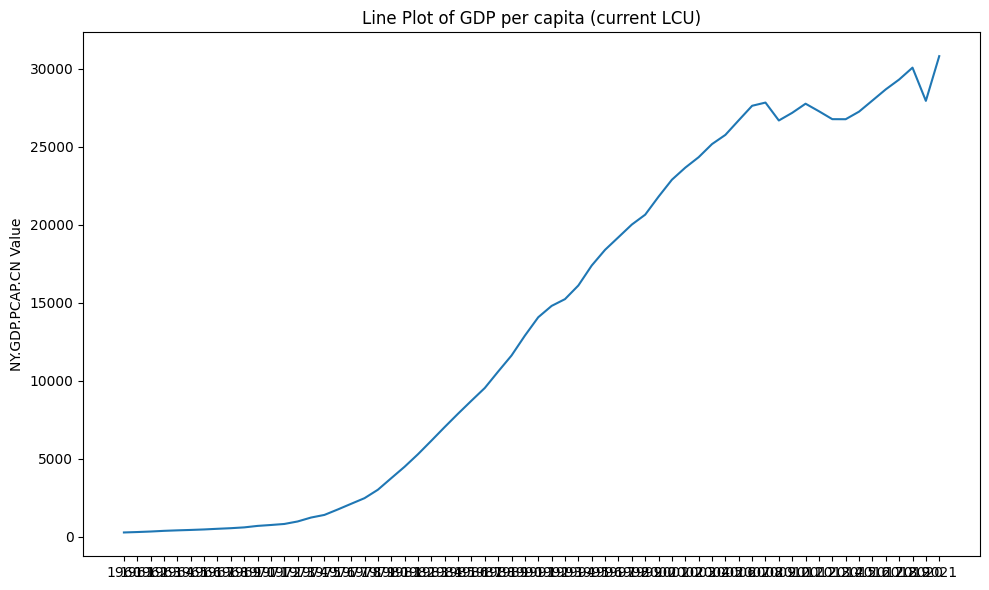

08/07/2024 05:58:33PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:33PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


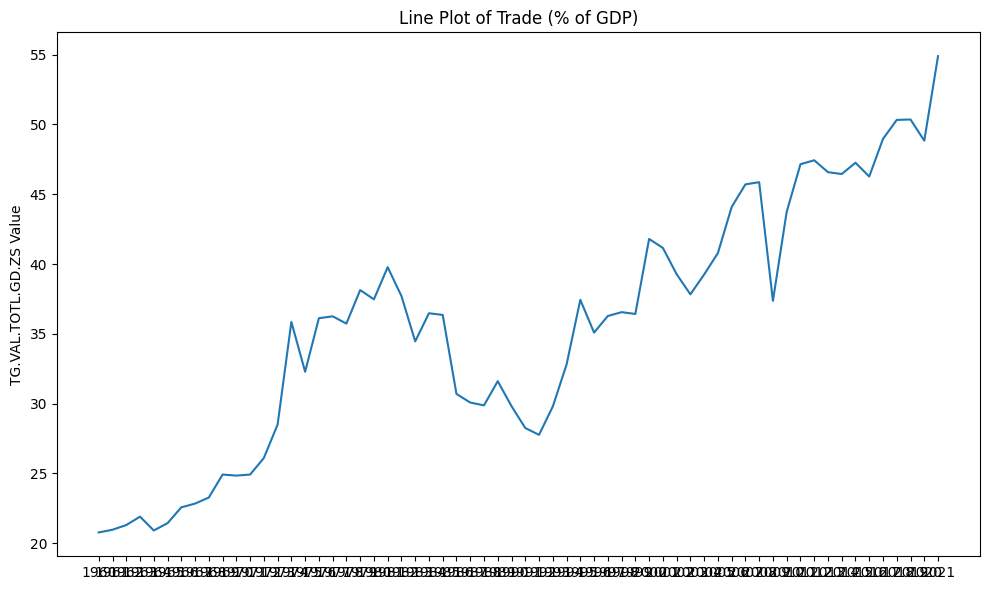

08/07/2024 05:58:33PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:33PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


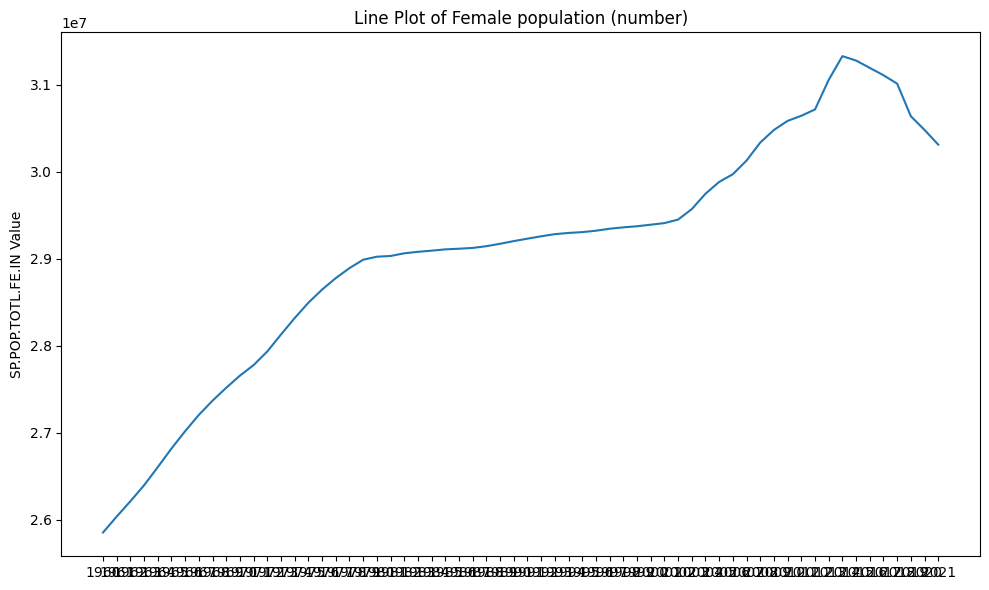

08/07/2024 05:58:34PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:34PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


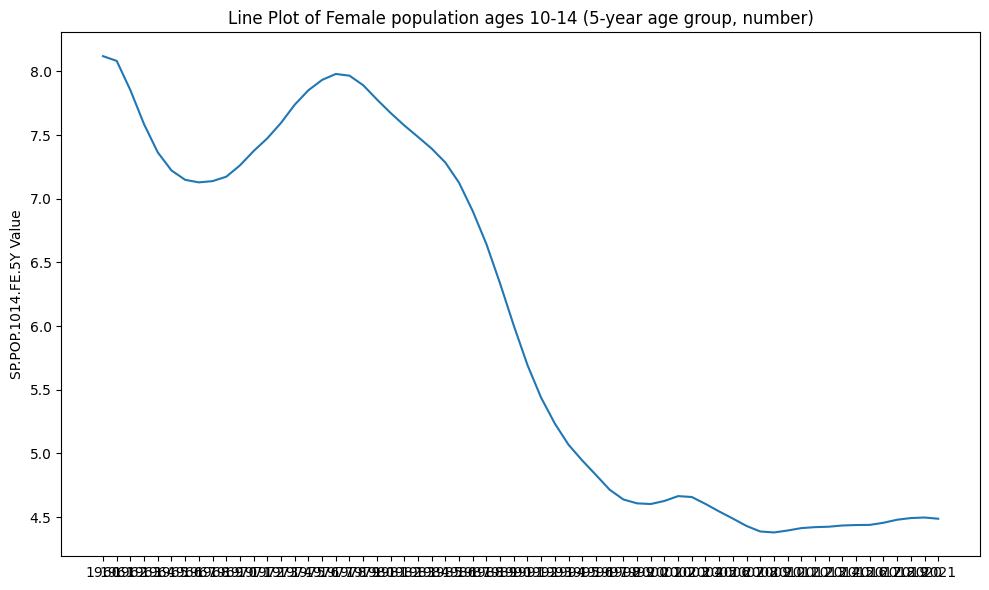

08/07/2024 05:58:34PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:34PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


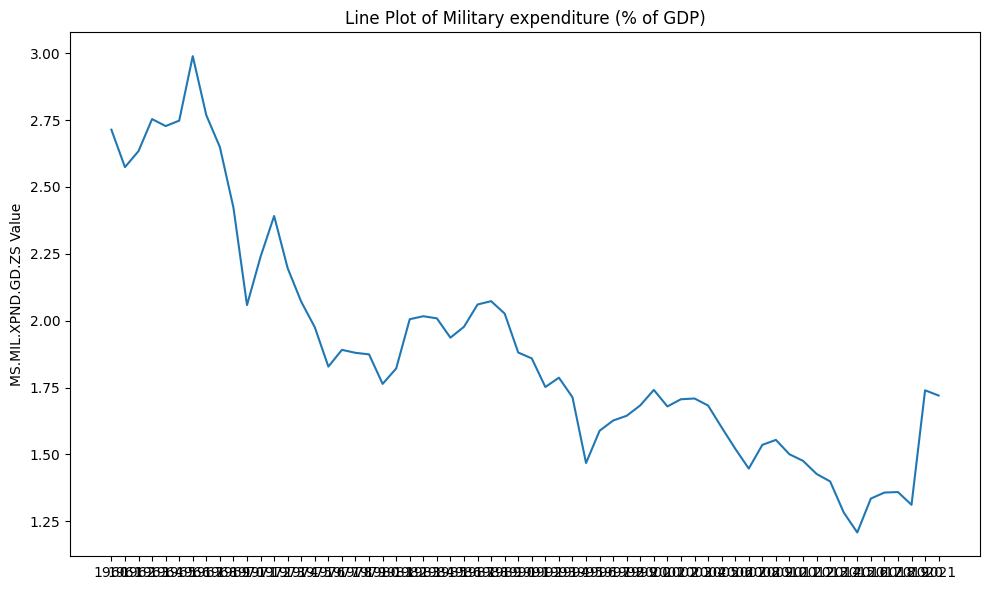

08/07/2024 05:58:34PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:34PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


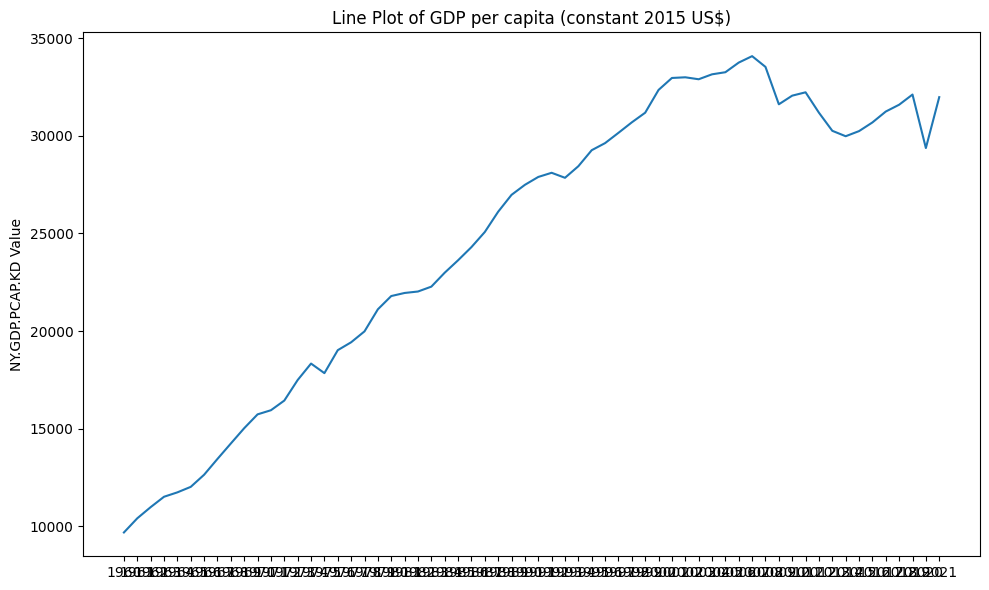

08/07/2024 05:58:34PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:34PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


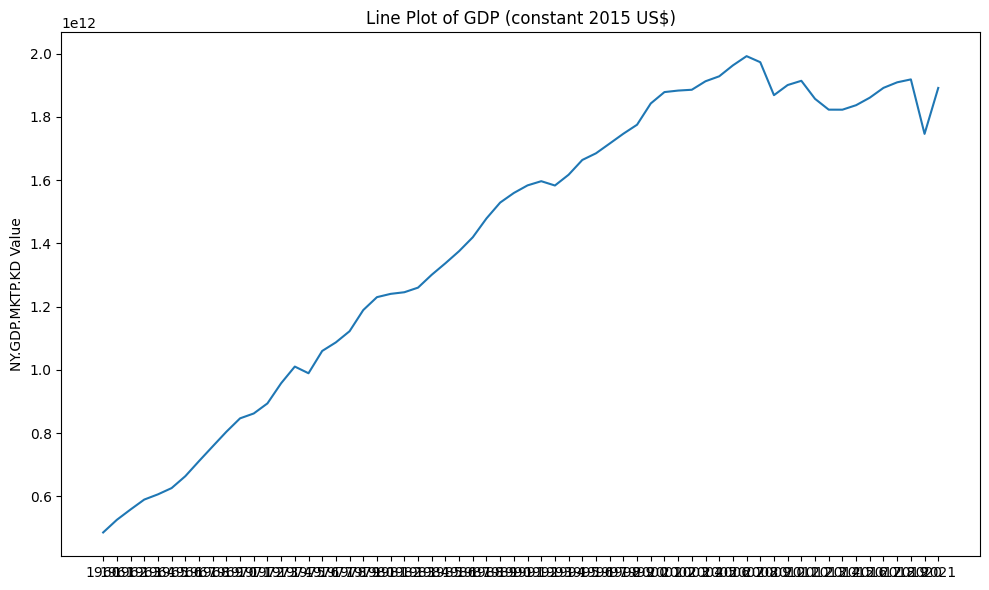

08/07/2024 05:58:35PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:35PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


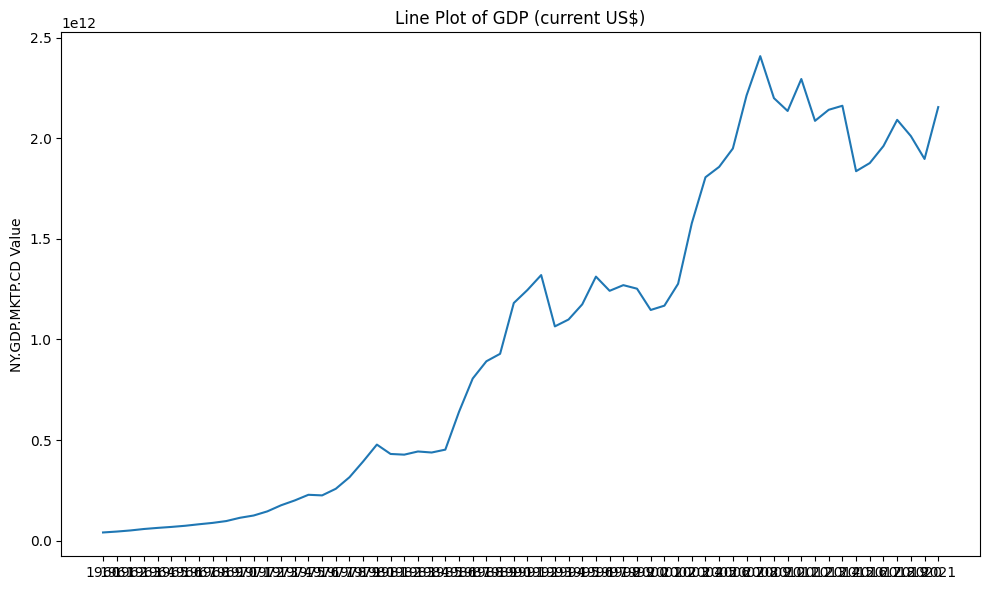

08/07/2024 05:58:35PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:35PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


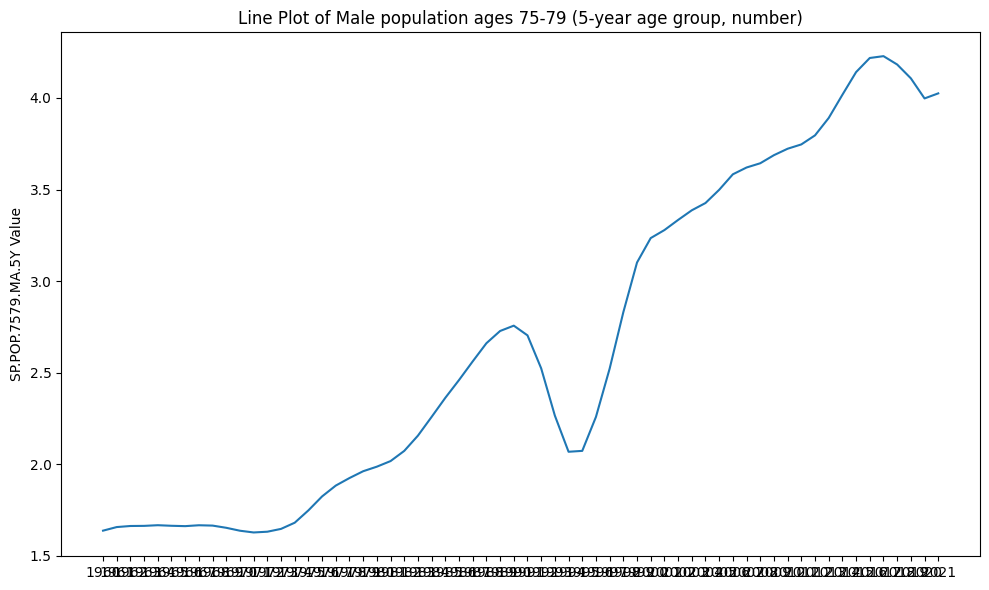

08/07/2024 05:58:35PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:35PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


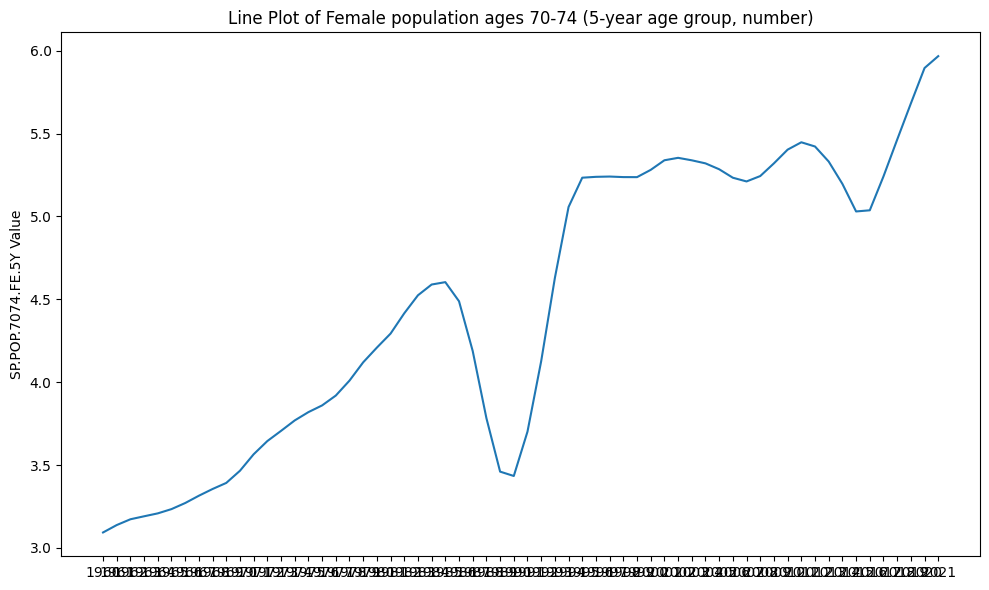

08/07/2024 05:58:35PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:35PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


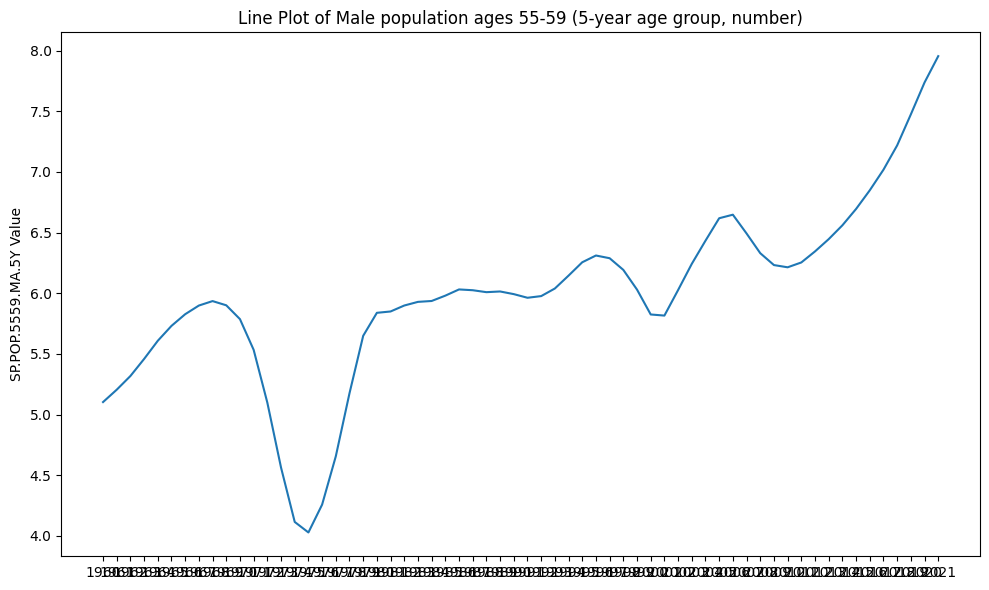

08/07/2024 05:58:36PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:36PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


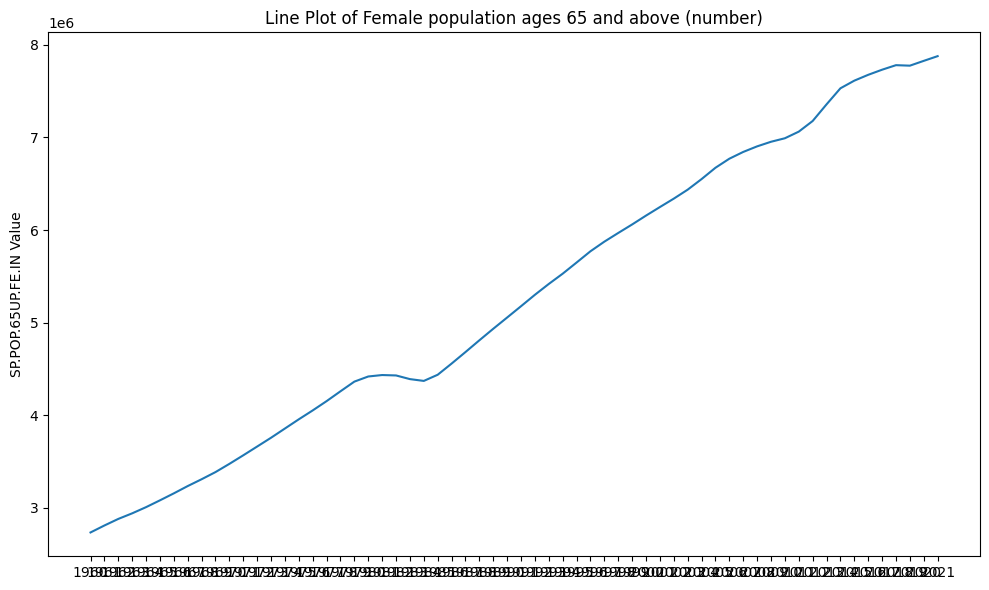

08/07/2024 05:58:36PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:36PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


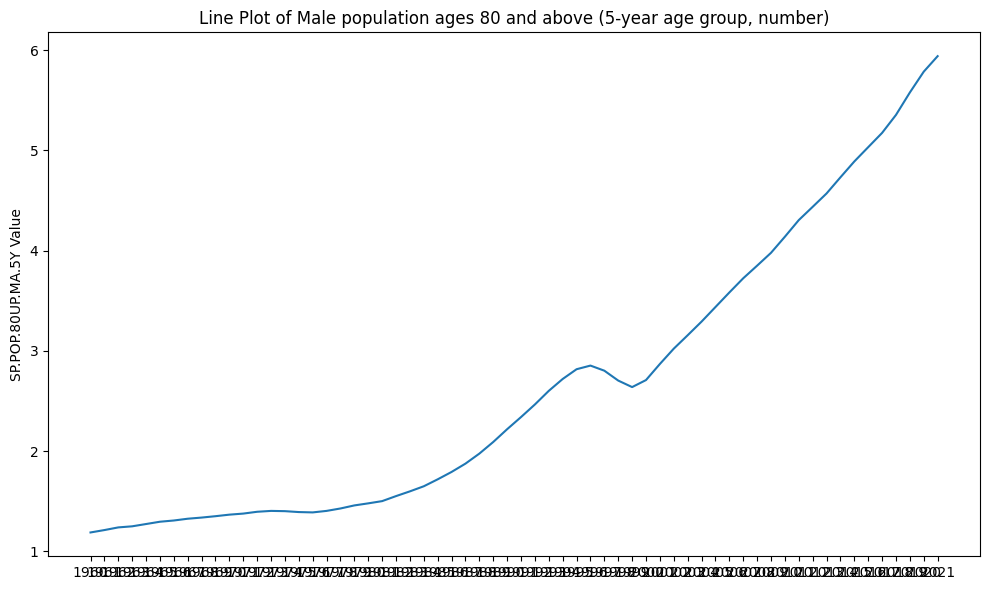

08/07/2024 05:58:36PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:36PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


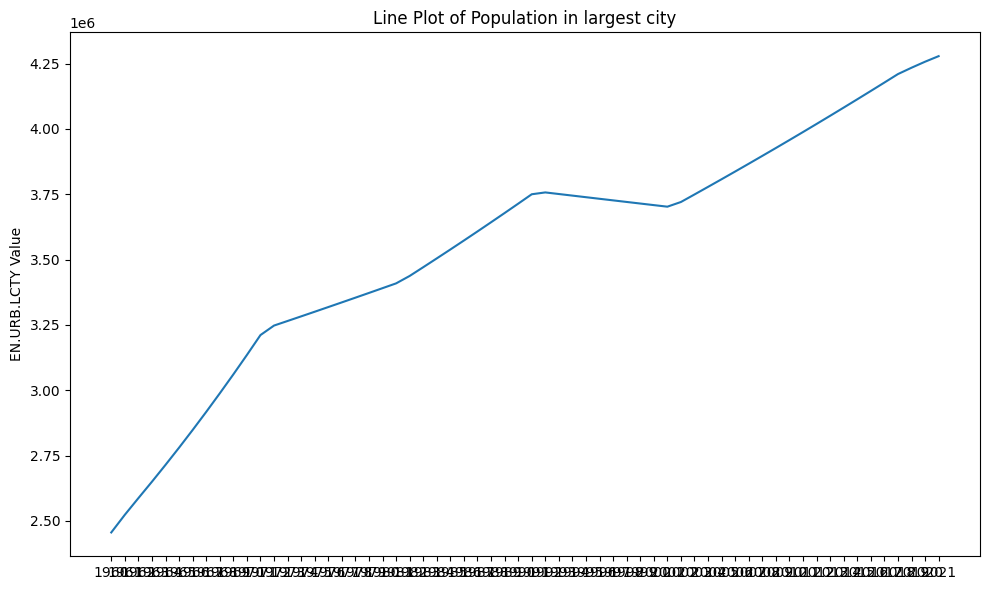

08/07/2024 05:58:36PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:36PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


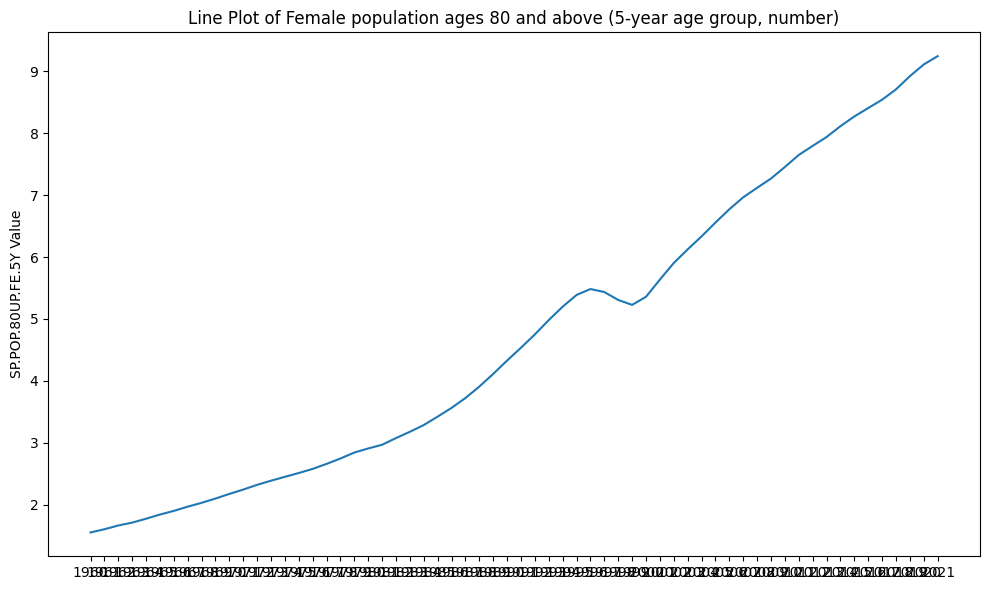

08/07/2024 05:58:37PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:37PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


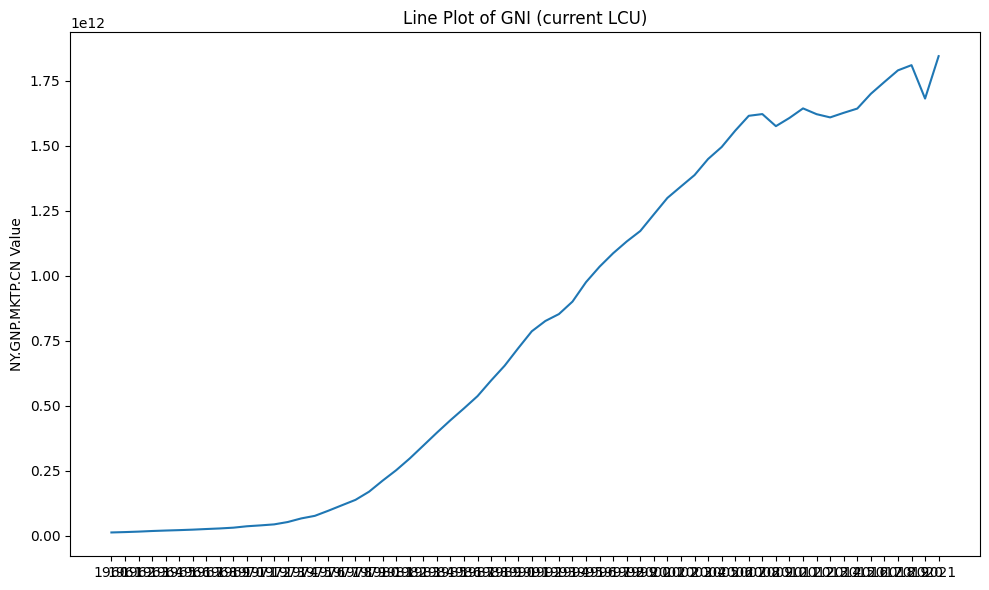

08/07/2024 05:58:37PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:37PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


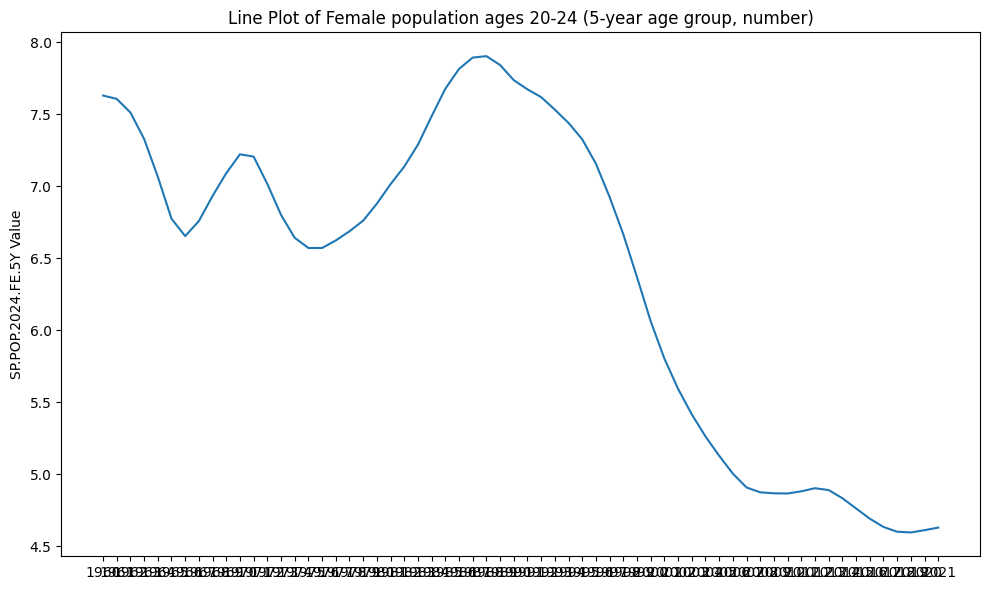

08/07/2024 05:58:37PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:37PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


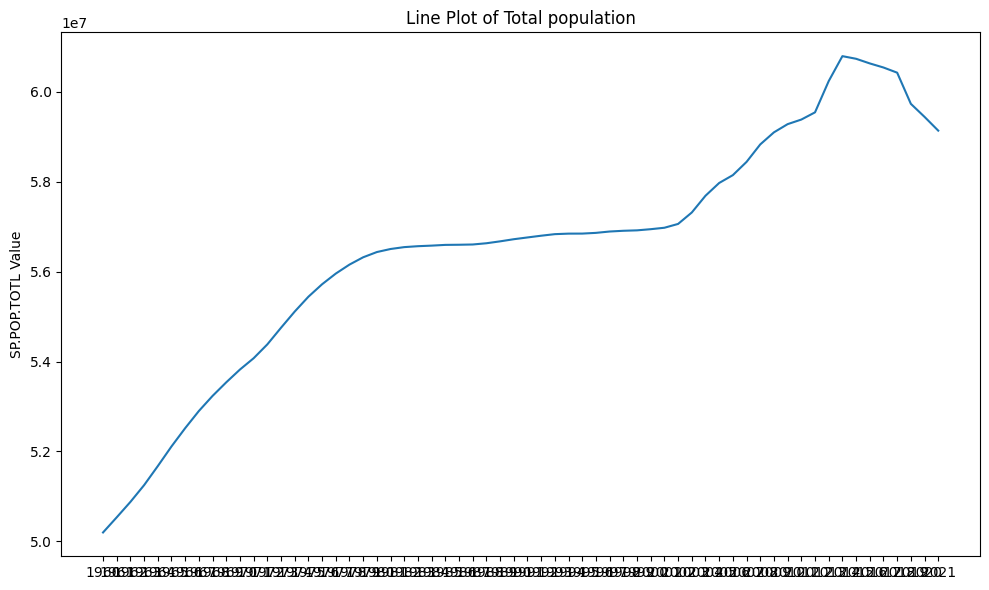

08/07/2024 05:58:38PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:38PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


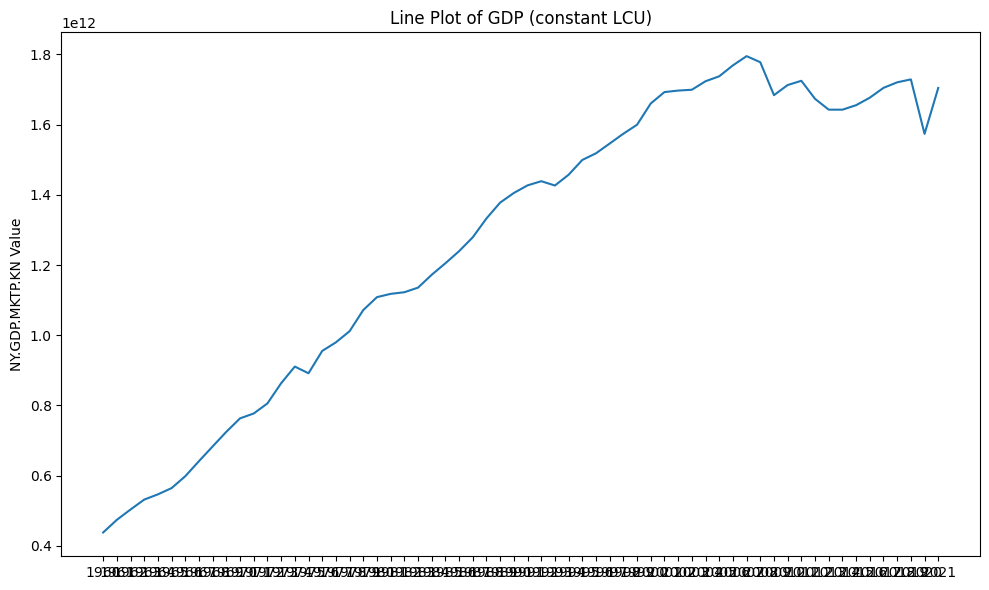

08/07/2024 05:58:38PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:38PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


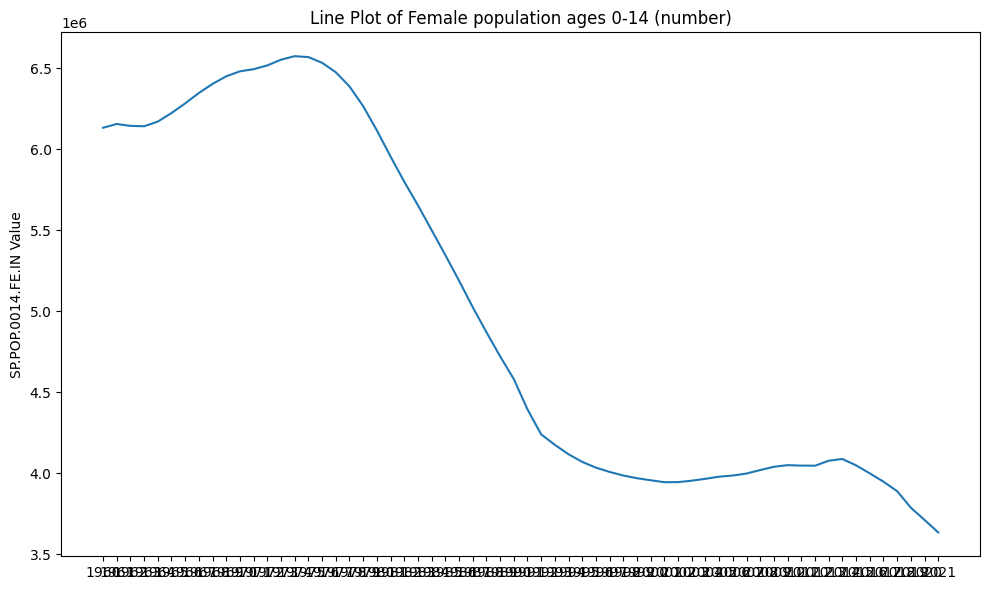

08/07/2024 05:58:38PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:38PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


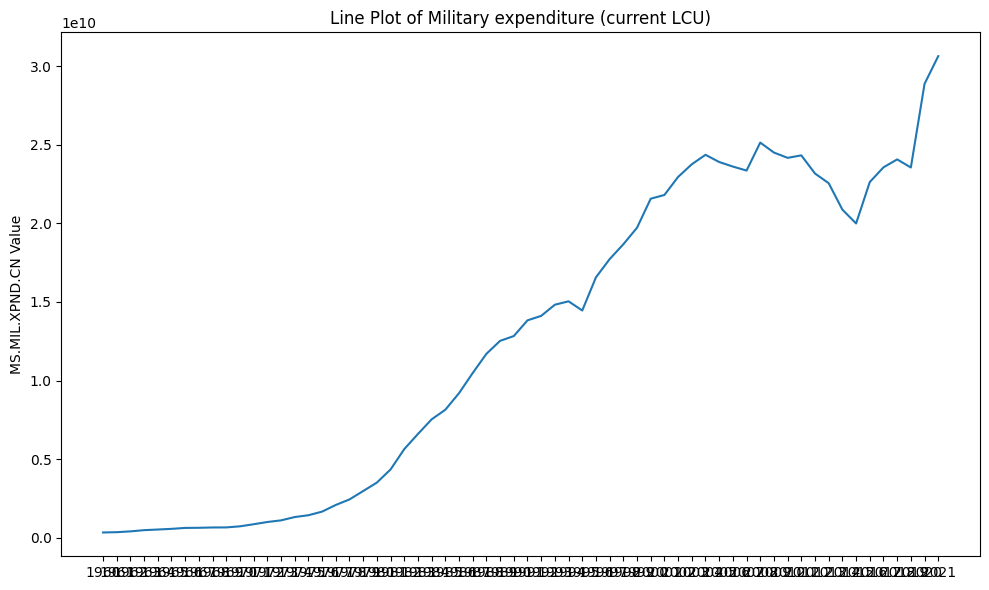

08/07/2024 05:58:38PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:38PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


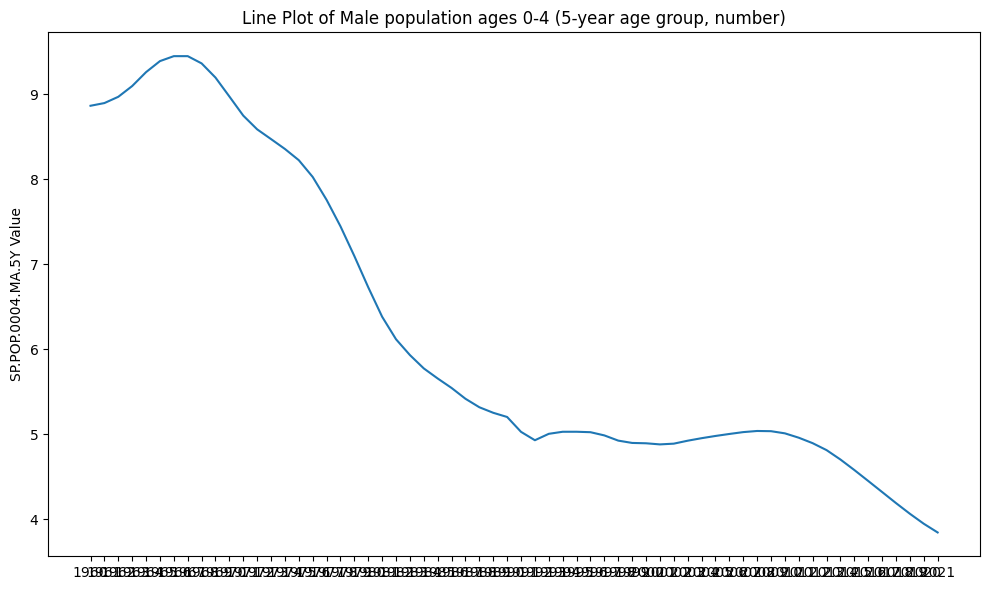

08/07/2024 05:58:39PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:39PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


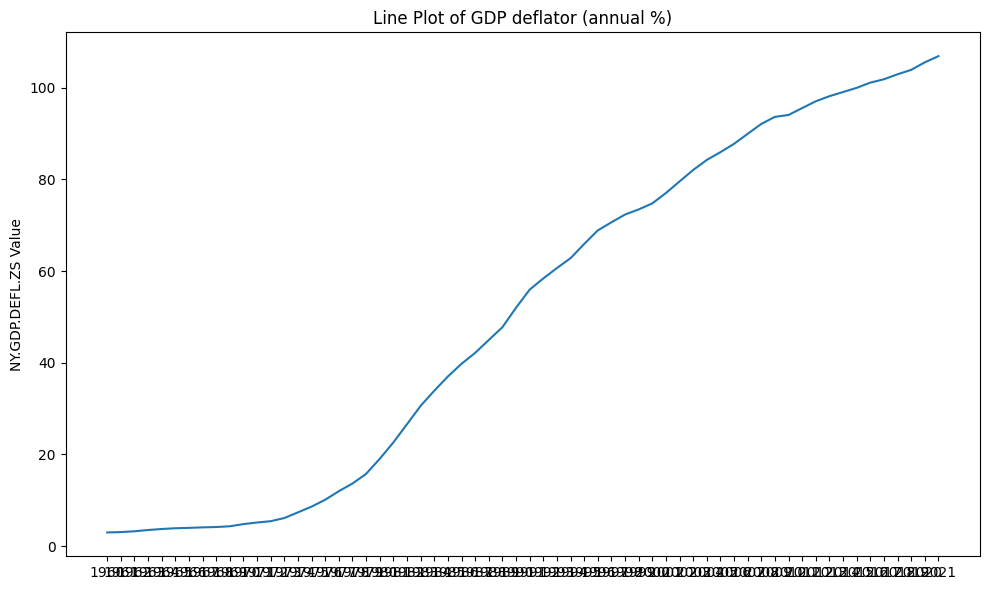

08/07/2024 05:58:39PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:39PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


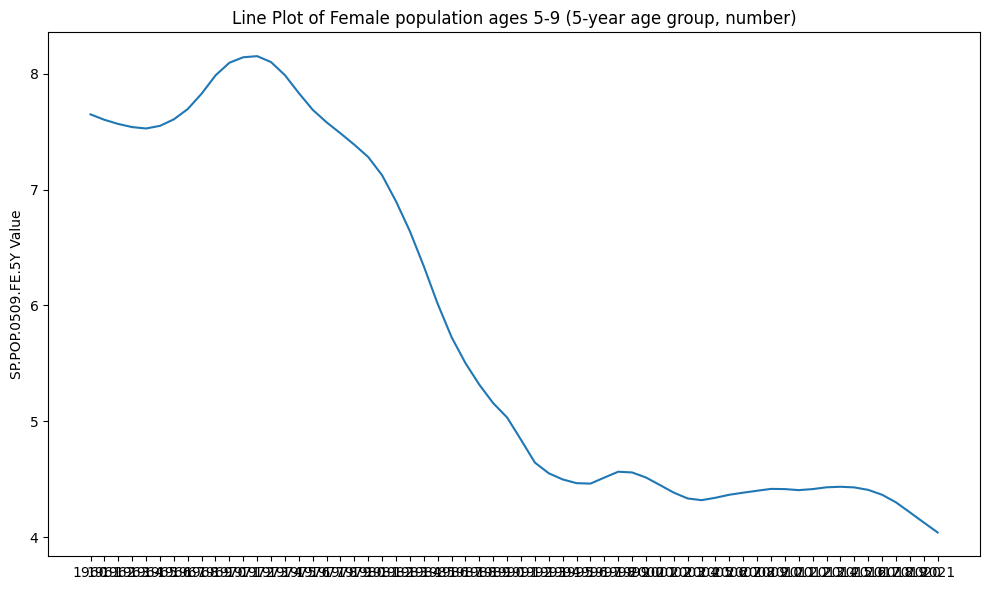

08/07/2024 05:58:39PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:39PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


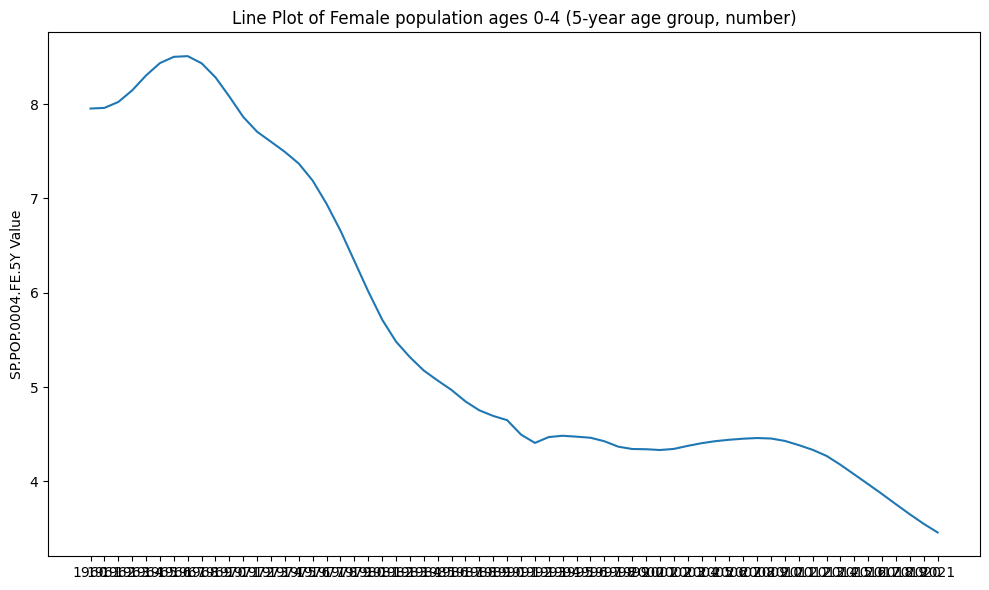

08/07/2024 05:58:39PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:39PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


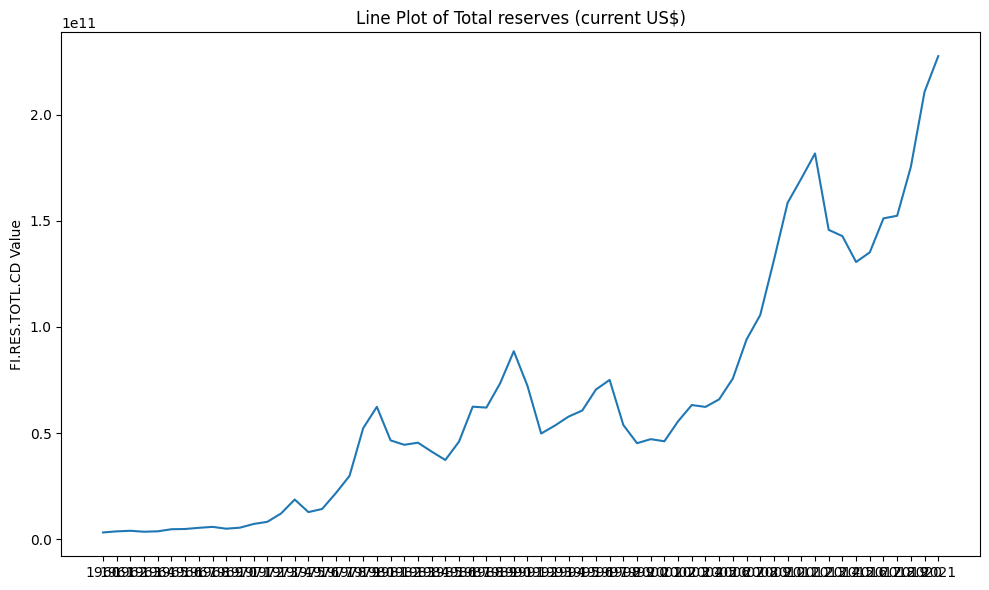

08/07/2024 05:58:40PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:40PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


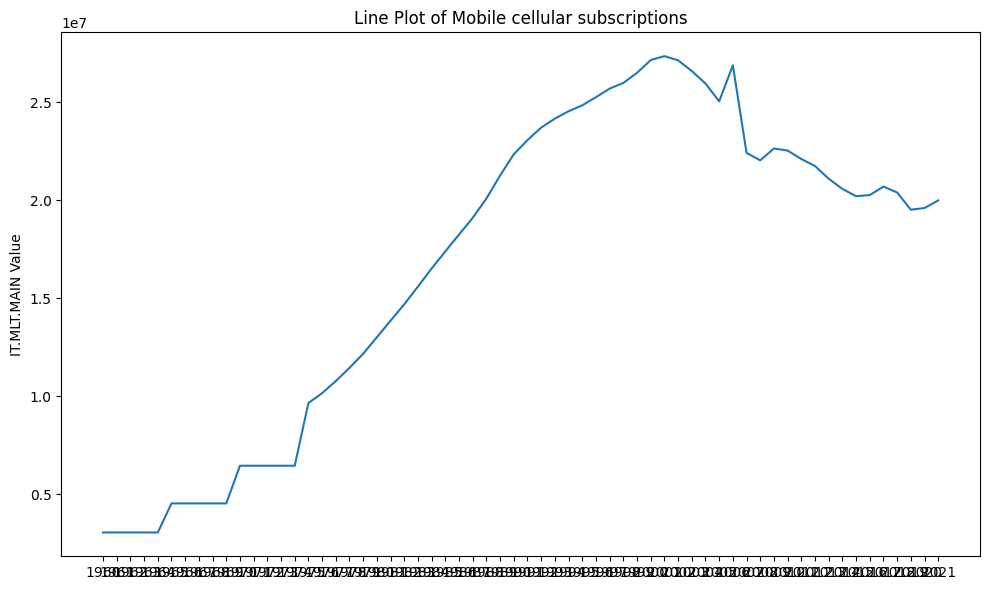

08/07/2024 05:58:40PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:40PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


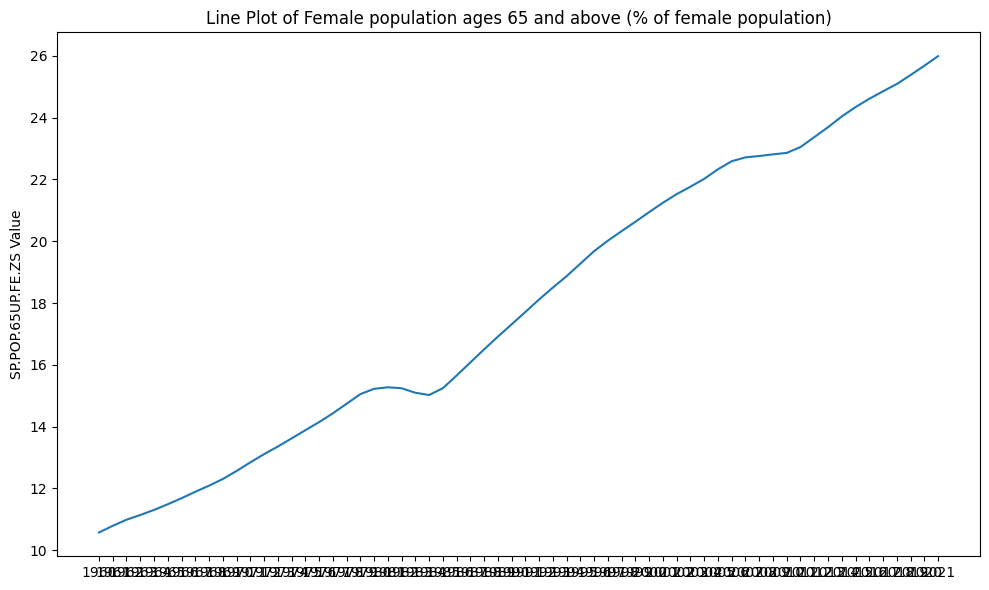

08/07/2024 05:58:40PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:40PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


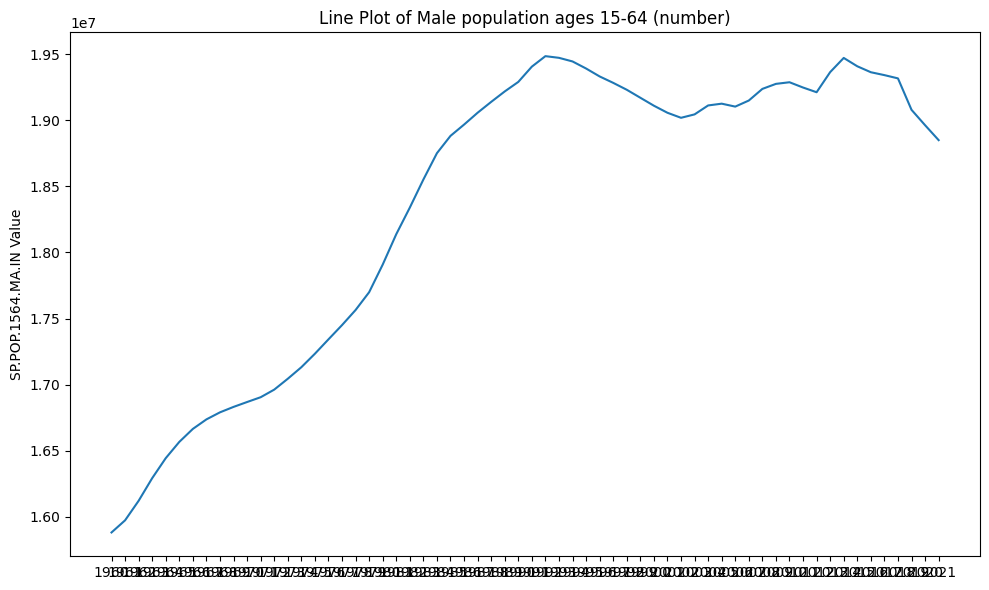

08/07/2024 05:58:41PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/07/2024 05:58:41PM - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


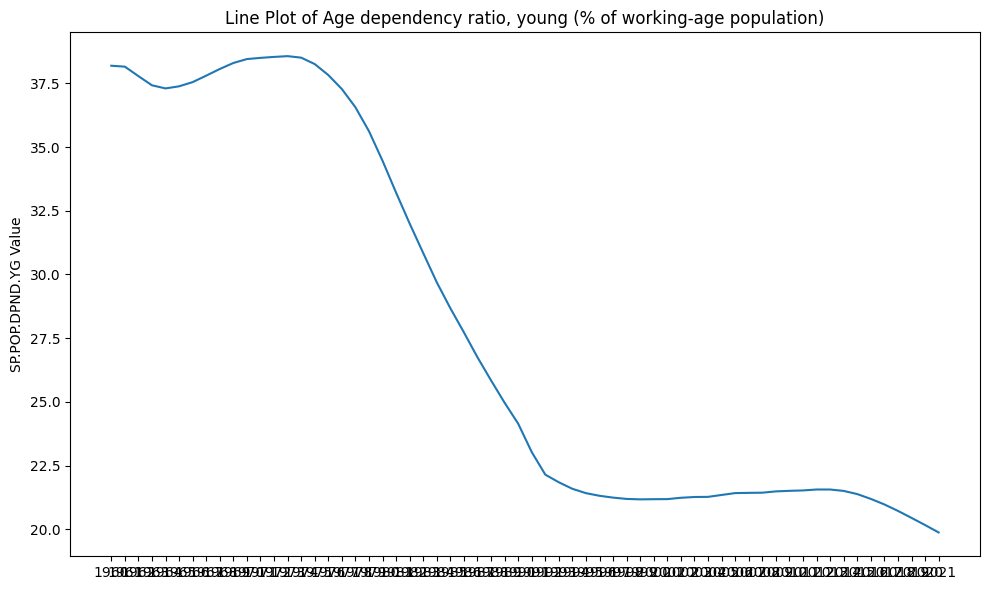

In [28]:
for column in highCorr_ita_subset:
    if column == 'target':
        continue
    plt.figure(figsize=(10, 6))
    plt.plot(highCorr_ita_subset[column])
    plt.title(f'Line Plot of {world_bank_data_ita_codes2name[column]}')
    # plt.xlabel('Index')
    plt.ylabel(f'{column} Value')
    plt.tight_layout()
    plt.show()

Pipeline 1

In [29]:
X = highCorr_ita_subset.drop('target', axis=1)
y = highCorr_ita_subset['target']



In [30]:
print(X.shape)
print(y.shape)

(62, 71)
(62,)


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=False)

In [32]:
print(X_train.shape)
print(X_test.shape) 

(49, 71)
(13, 71)


In [33]:
from xgboost import XGBRegressor
# Create and train the XGBoost model
regressor = XGBRegressor()
regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [34]:
results_train = y_train.reset_index()
results_test = y_test.reset_index()
results_train['Prediction'] = regressor.predict(X_train)
results_test['Prediction'] = regressor.predict(X_test)

In [35]:
full_hist = pd.concat([results_train, results_test])

# extract test data
test_hist = full_hist.iloc[-13:, :]

print(test_hist)

   index        target    Prediction
0   2009  2.136100e+12  2.039295e+12
1   2010  2.294994e+12  2.039295e+12
2   2011  2.086958e+12  2.039295e+12
3   2012  2.141924e+12  2.039295e+12
4   2013  2.162010e+12  1.934222e+12
5   2014  1.836638e+12  1.926980e+12
6   2015  1.877072e+12  2.039295e+12
7   2016  1.961796e+12  2.039295e+12
8   2017  2.091932e+12  2.039295e+12
9   2018  2.011302e+12  2.039295e+12
10  2019  1.897462e+12  2.038210e+12
11  2020  2.155360e+12  2.017083e+12
12  2021  2.049737e+12  2.017083e+12


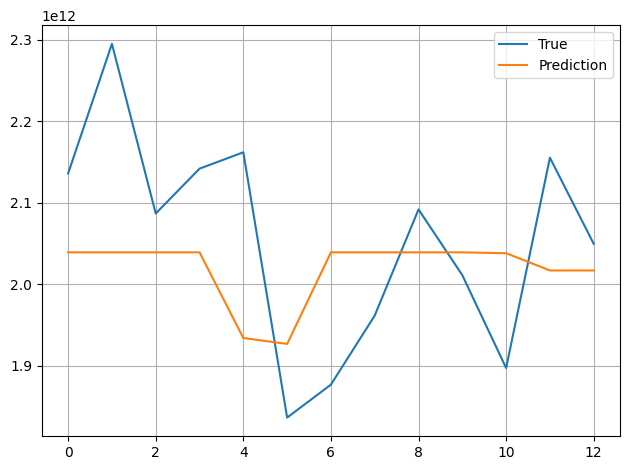

In [36]:
plt.plot(test_hist['target'], label='True')
plt.plot(test_hist['Prediction'], label='Prediction')
plt.tight_layout()
plt.grid()
plt.legend()
plt.show()


Pipeline 2

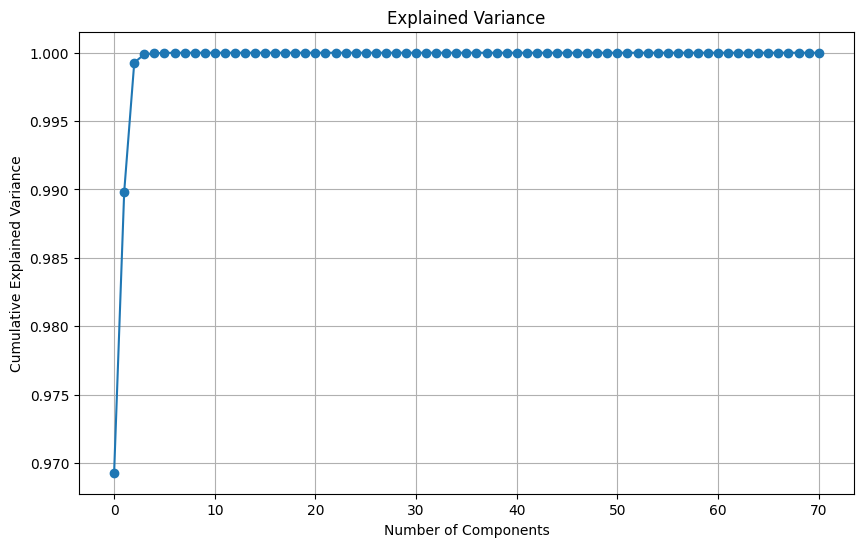

In [37]:
# Perform PCA on the training data

eigenvalues, eigenvectors = np.linalg.eig(X_train.cov())

# Sort the eigenvalues and eigenvectors
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Calculate the explained variance
explained_variance = eigenvalues / eigenvalues.sum()

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o')
plt.title('Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()  
plt.show()


In [38]:
# perform pca with 4 components on the highCorr_ita_subset
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(X_train_pca.shape)
print(X_test_pca.shape)

(49, 4)
(13, 4)


In [39]:
from xgboost import XGBRegressor
# Create and train the XGBoost model
regressor = XGBRegressor()
regressor.fit(X_train_pca, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [40]:
results_train = y_train.reset_index()
results_test = y_test.reset_index()
results_train['Prediction'] = regressor.predict(X_train_pca)
results_test['Prediction'] = regressor.predict(X_test_pca)

In [41]:
full_hist = pd.concat([results_train, results_test])

# extract test data
test_hist = full_hist.iloc[-13:, :]

print(test_hist)

   index        target    Prediction
0   2009  2.136100e+12  2.213089e+12
1   2010  2.294994e+12  2.213225e+12
2   2011  2.086958e+12  2.408598e+12
3   2012  2.141924e+12  2.213181e+12
4   2013  2.162010e+12  2.213230e+12
5   2014  1.836638e+12  2.213230e+12
6   2015  1.877072e+12  1.919342e+12
7   2016  1.961796e+12  1.919465e+12
8   2017  2.091932e+12  2.213184e+12
9   2018  2.011302e+12  2.213184e+12
10  2019  1.897462e+12  2.213184e+12
11  2020  2.155360e+12  1.919465e+12
12  2021  2.049737e+12  2.408533e+12


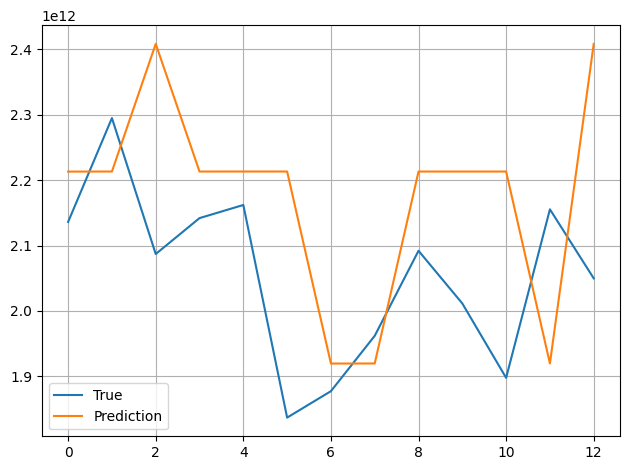

In [42]:
plt.plot(test_hist['target'], label='True')
plt.plot(test_hist['Prediction'], label='Prediction')
plt.tight_layout()
plt.grid()
plt.legend()
plt.show()


Pipeline 3

In [43]:

from sklearn.linear_model import Lasso

lasso = Lasso()

lasso.fit(X_train, y_train)

results_train = y_train.reset_index()
results_test = y_test.reset_index()

results_train['Prediction'] = lasso.predict(X_train)
results_test['Prediction'] = lasso.predict(X_test)

full_hist = pd.concat([results_train, results_test])

# extract test data 
test_hist = full_hist.iloc[-13:, :]

print(test_hist)


   index        target    Prediction
0   2009  2.136100e+12  2.360428e+12
1   2010  2.294994e+12  2.623507e+12
2   2011  2.086958e+12  2.811775e+12
3   2012  2.141924e+12  3.077562e+12
4   2013  2.162010e+12  3.067796e+12
5   2014  1.836638e+12  3.316582e+12
6   2015  1.877072e+12  3.594745e+12
7   2016  1.961796e+12  3.694571e+12
8   2017  2.091932e+12  3.915533e+12
9   2018  2.011302e+12  4.114642e+12
10  2019  1.897462e+12  4.558726e+12
11  2020  2.155360e+12  4.460257e+12
12  2021  2.049737e+12  4.727575e+12


   index        target    Prediction
0   1960  4.484276e+10  7.579378e+09
1   1961  5.038389e+10  8.301240e+10
2   1962  5.771074e+10  7.695570e+10
3   1963  6.317542e+10  5.331327e+10
4   1964  6.797815e+10  4.874969e+10
5   1965  7.365487e+10  8.353642e+10
6   1966  8.113312e+10  1.025336e+11
7   1967  8.794223e+10  9.207882e+10
8   1968  9.708508e+10  8.141922e+10
9   1969  1.133953e+11  9.351642e+10
10  1970  1.246724e+11  1.200686e+11
11  1971  1.452600e+11  1.753429e+11
12  1972  1.754921e+11  1.932119e+11
13  1973  1.995645e+11  1.883543e+11
14  1974  2.276959e+11  2.223376e+11
15  1975  2.247173e+11  2.014458e+11
16  1976  2.575963e+11  2.545502e+11
17  1977  3.150583e+11  3.164954e+11
18  1978  3.936772e+11  3.925512e+11
19  1979  4.772568e+11  4.892294e+11
20  1980  4.307029e+11  4.855355e+11
21  1981  4.272726e+11  4.043216e+11
22  1982  4.430424e+11  3.872038e+11
23  1983  4.378877e+11  4.419259e+11
24  1984  4.522175e+11  5.091031e+11
25  1985  6.403864e+11  6.027874e+11
2

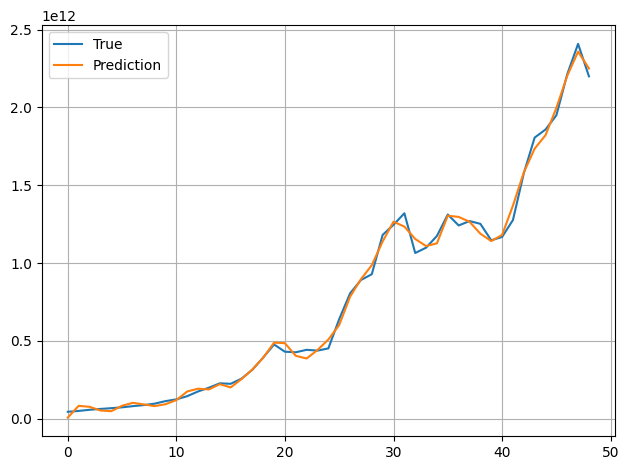

In [44]:
# extract train 
train_hist = full_hist.iloc[:-13, :]
print(train_hist)

plt.plot(train_hist['target'], label='True')
plt.plot(train_hist['Prediction'], label='Prediction')
plt.tight_layout()
plt.grid()
plt.legend()
plt.show()


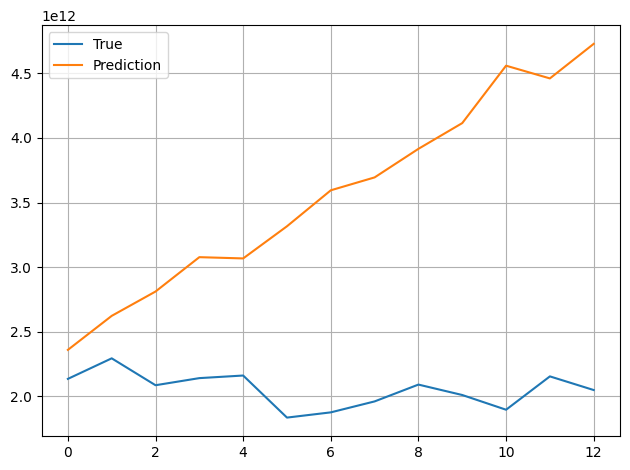

In [45]:
plt.plot(test_hist['target'], label='True')
plt.plot(test_hist['Prediction'], label='Prediction')
plt.tight_layout()
plt.grid()
plt.legend()
plt.show()

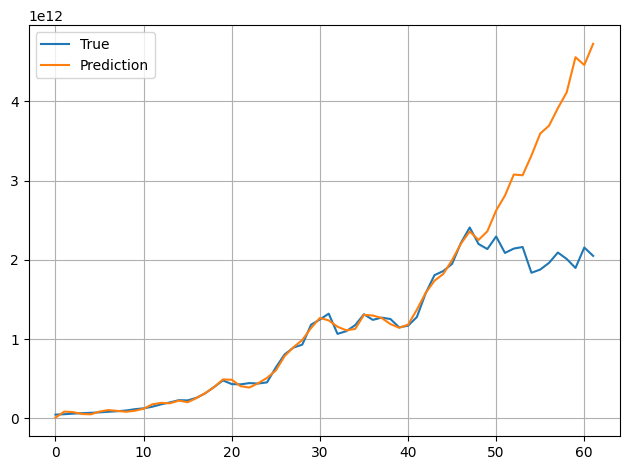

In [46]:
#rename the index of test_hist to be the year continuining from the last year of the training data
test_hist.index = [str(int(train_hist.index[-1]) + i + 1) for i in range(13)]
full_hist = pd.concat([train_hist, test_hist])
plt.plot(full_hist['target'], label='True')
plt.plot(full_hist['Prediction'], label='Prediction')
plt.tight_layout()
plt.grid()
plt.legend()
plt.show()


Pipeline 4

In [47]:
# help me create a lasso regression on the highCorr_ita_subset
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.9)

lasso.fit(X_train_pca, y_train)

results_train = y_train.reset_index()
results_test = y_test.reset_index()

results_train['Prediction'] = lasso.predict(X_train_pca)
results_test['Prediction'] = lasso.predict(X_test_pca)

full_hist = pd.concat([results_train, results_test])

# extract test data 
test_hist = full_hist.iloc[-13:, :]

print(test_hist)

   index        target    Prediction
0   2009  2.136100e+12  2.188713e+12
1   2010  2.294994e+12  2.179487e+12
2   2011  2.086958e+12  2.333451e+12
3   2012  2.141924e+12  2.154016e+12
4   2013  2.162010e+12  2.186510e+12
5   2014  1.836638e+12  2.206000e+12
6   2015  1.877072e+12  1.945821e+12
7   2016  1.961796e+12  1.992427e+12
8   2017  2.091932e+12  2.087123e+12
9   2018  2.011302e+12  2.213969e+12
10  2019  1.897462e+12  2.150022e+12
11  2020  2.155360e+12  2.007610e+12
12  2021  2.049737e+12  2.297037e+12


   index        target    Prediction
0   1960  4.484276e+10  2.944551e+10
1   1961  5.038389e+10  3.837876e+10
2   1962  5.771074e+10  4.725019e+10
3   1963  6.317542e+10  5.747909e+10
4   1964  6.797815e+10  6.394204e+10
5   1965  7.365487e+10  7.056624e+10
6   1966  8.113312e+10  8.039842e+10
7   1967  8.794223e+10  9.286626e+10
8   1968  9.708508e+10  1.047329e+11
9   1969  1.133953e+11  1.187670e+11
10  1970  1.246724e+11  1.379395e+11
11  1971  1.452600e+11  1.491891e+11
12  1972  1.754921e+11  1.703118e+11
13  1973  1.995645e+11  2.045720e+11
14  1974  2.276959e+11  2.357583e+11
15  1975  2.247173e+11  2.548452e+11
16  1976  2.575963e+11  2.672301e+11
17  1977  3.150583e+11  3.003705e+11
18  1978  3.936772e+11  3.535858e+11
19  1979  4.772568e+11  4.325627e+11
20  1980  4.307029e+11  5.113859e+11
21  1981  4.272726e+11  4.835511e+11
22  1982  4.430424e+11  4.870000e+11
23  1983  4.378877e+11  5.062681e+11
24  1984  4.522175e+11  5.180455e+11
25  1985  6.403864e+11  5.421224e+11
2

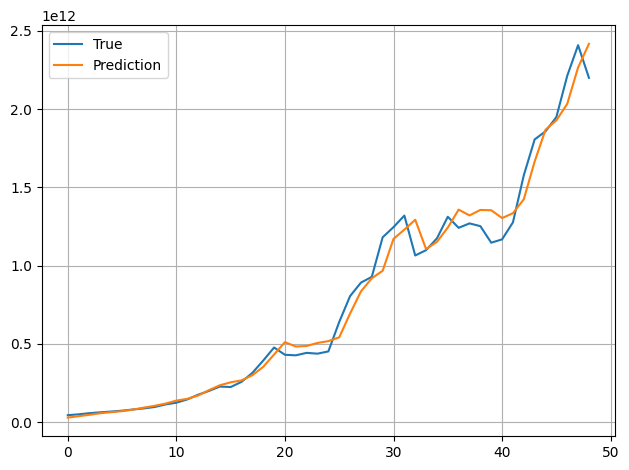

In [48]:
# extract train 
train_hist = full_hist.iloc[:-13, :]
print(train_hist)

plt.plot(train_hist['target'], label='True')
plt.plot(train_hist['Prediction'], label='Prediction')
plt.tight_layout()
plt.grid()
plt.legend()
plt.show()


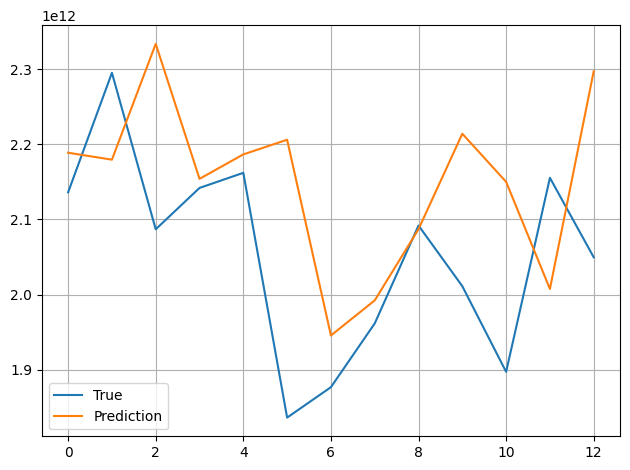

In [49]:
plt.plot(test_hist['target'], label='True')
plt.plot(test_hist['Prediction'], label='Prediction')
plt.tight_layout()
plt.grid()
plt.legend()
plt.show()